# Analysis of the L1-21J impact event on the Moon

*"Location, orbit and energy of a meteoroid impacting the moon during the Lunar Eclipse of January 21, 2019* by Jorge I. Zuluaga, Matipon Tangmatitham, Pablo A. Cuartas, Jonathan Ospina, Sergio López, Fritz Pichardo & Karl Peña

This is the latest version (May. 22/2019) after the first revision of the paper in Icarus. It improves the estimation of the speed distribution using the (non-central) moments of the GRT impact speeds.

In [1]:
BDIR="./"

## Global

You may modify this options to obtain different results

In [2]:
#Population
tpop="neos"
#tpop="alt"

## Preparing the Environment

Please skip if you are working on a Jupyter environment

In [3]:
#ENVIRONMENT="Colaboratory"
ENVIRONMENT="Jupyter"
DATADIR="MoonFlashes"

In [4]:
if ENVIRONMENT=="Colaboratory":
  try:
    import spiceypy
  except:
    !pip install spiceypy
  from google.colab import drive,files
  drive.mount('/content/gdrive')
  
  BDIR=f"gdrive/My Drive/{DATADIR}/"
else:
  BDIR="./"
from glob import glob 
if len(glob(f"{BDIR}/data"))==0:
  print("You are not in the proper directory.  Please correct")
else:
  print("Home, sweet home")

Home, sweet home


## External modules, constants and useful routines

### External modules and macros

In [5]:
###################################################################
#EXTERNAL MODULES
###################################################################
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
import pandas as pd
from scipy.optimize import minimize,bisect
from scipy import optimize
from scipy.interpolate import interp1d as interpolate
from scipy.integrate import quad as integrate
import statistics as stats
import spiceypy as spy
from copy import deepcopy
from tqdm import tqdm
from collections import OrderedDict
import math
from time import time,strftime
from scipy.stats import multivariate_normal as multinorm
from scipy.integrate import quad as integral

if ENVIRONMENT=="Colaboratory":
    %matplotlib inline
else:
    %matplotlib nbagg

###################################################################
#INITIALIZE SPICE
###################################################################
spy.furnsh(BDIR+"kernels/de430.bsp")
spy.furnsh(BDIR+"kernels/naif0012.tls")
spy.furnsh(BDIR+"kernels/pck00010.tpc")
spy.furnsh(BDIR+"kernels/moon_pa_de421_1900-2050.bpc")

#Useful package routines
norm=np.linalg.norm

In [6]:
if ENVIRONMENT=="Colaboratory":
    %matplotlib inline
else:
    %matplotlib nbagg

### Constants and Macros

In [7]:
###################################################################
#NUMERICAL
###################################################################
#Angle conversion
DEG=np.pi/180
RAD=1/DEG

###################################################################
#PHYSICAL 
###################################################################
#Tons of TNT
TTNT=4.184e9 #J

#Regolith density
RHO_REG=1600 #kg/m^3

#Density of bodies
if tpop=="neos":
    RHO_COMET=1000
    P_COMET=0.01
    RHO_ROCKY=2500
    P_ROCKY=0.59
    RHO_METAL=3700
    P_METAL=1-P_COMET-P_ROCKY
if tpop=="sporadic":
    RHO_COMET=1000
    P_COMET=0.98
    RHO_ROCKY=2500
    P_ROCKY=0.01
    RHO_METAL=3700
    P_METAL=1-P_COMET-P_ROCKY
    
###################################################################
#IMPACT DATA
###################################################################
IMPACT_DATA="L1-21J"
IMPACT_SUFFIX="lat_-2.94288e+01__lon_-6.81674e+01"
IMPACT_FIGDIR=f"{BDIR}/data/{IMPACT_DATA}"
IMPACT_LOC=dict(
    lon=-29.428816, #degrees, 29°25'43.74"S
    lat=-68.167435, #degrees, 68°10'2.77"O
    alt=0.510 #km
)
IMPACT_FLASH=0.30
IMPACT_DATE="01/21/2019"
IMPACT_TIME="04:41:38 UTC"

#Ephemeris Time
t=spy.str2et(IMPACT_DATE+" "+IMPACT_TIME)
dt=spy.deltet(t,"et")
IMPACT_ET=t-dt
print(f"Time of the eclipse: {IMPACT_DATE} (TDB = {IMPACT_ET}, Delta t = {dt}")

#Sideral time at the moment of the impact
GST=12.71279 #H

###################################################################
#ASTRONOMICAL CONDITIONS
###################################################################
moonpos,tf=spy.spkezr("MOON",IMPACT_ET,"J2000","NONE","EARTH")
MOON_DISTANCE=norm(moonpos[:4]) #km
print(f"Moon distance at the time of impact (km): {MOON_DISTANCE}")

#Moon size
n,rs=spy.bodvrd("MOON","RADII",3)
RMOON=rs[0]
FMOON=0.0
print(f"Moon equatorial radius (km): {RMOON}")

#Location of the Moon in the sky
r,RA_MOON,DEC_MOON=spy.reclat(moonpos[:3])
RA_MOON=24+RA_MOON*RAD/15 if RA_MOON<0 else RA_MOON*RAD/15
DEC_MOON*=RAD
print(f"Position of the Moon as seen from Earth: {RA_MOON,DEC_MOON}")

#Moon reference frame matrix transformation
Moon2j2000=spy.pxform("IAU_MOON","J2000",IMPACT_ET)

#Location of the Earth at the time of the eclipse
r,RA_EARTH,DEC_EARTH=spy.reclat(-moonpos[:3])
RA_EARTH=24+RA_EARTH*RAD/15 if RA_EARTH<0 else RA_EARTH*RAD/15
DEC_EARTH*=RAD
print(f"Position of the Earth as seen from the moon: {RA_EARTH,DEC_EARTH}")

#Earth size
n,rs=spy.bodvrd("EARTH","RADII",3)
REARTH=rs[0]
FEARTH=(rs[0]-rs[2])/rs[0]
print(f"Earth shape (km): RE = {REARTH} km , 1/f = {1/FEARTH}")

###################################################################
#OTHER NUMERICAL CONSTANTS
###################################################################
#Filter calibration, http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php
NG=2.500e-11 #W/m^2/nm
G0=0.03
DLAMBDA=420.360 #Weff, nm


###################################################################
#LUMINOUS EFFICIENCY
###################################################################
eta_min=1.8e-3
eta_max=3.4e-3
logeta_min=np.log10(eta_min)
logeta_max=np.log10(eta_max)
logeta_mean=(logeta_min+logeta_max)/2
dlogeta=logeta_mean-logeta_min
print(f"log(eta) = {logeta_mean}+/-{dlogeta}")

#Plate constants
PLATECONST=[-1.e-6,-1.e-7,8.16,-1.e-5,-1.e-4,19.7] 
PHOTOMETRY_COEFS=np.array([23.66200566,  0.42782257,  -5.9073529 ,1.73859671 ])

#REF_LUNARSITE="L1-21J"
REF_LUNARSITE="Moon Center"
CENTER_LUNARSITE="Moon Center"

Time of the eclipse: 01/21/2019 (TDB = 601317698.0, Delta t = 69.18449230785387
Moon distance at the time of impact (km): 357745.19348597113
Moon equatorial radius (km): 1737.4
Position of the Moon as seen from Earth: (8.166039257679454, 20.436535879618923)
Position of the Earth as seen from the moon: (20.166039257679454, -20.436535879618923)
Earth shape (km): RE = 6378.1366 km , 1/f = 298.25700617731906
log(eta) = -2.6066242889272195+/-0.13810320596947445


### Routines

In [8]:
###################################################################
#ROUTINES
###################################################################
def val2Exp(value,fmt="%.1f",text=False):
    sgn=np.sign(value)
    pot=np.floor(np.log10(np.abs(value)))
    man=value/10**pot
    man=fmt%man
    pot="%d"%pot
    if text:return f"%s\EE{{%s}}"%(man,pot)
    return man,pot

def str2vec(str):
    v=np.array([float(x) for x in str.split(" ")])
    return v

def angle(u,v):
    return np.arccos(np.dot(u,v)/(norm(u)*norm(v)))*180/np.pi

def randomX(xs,ps,N=100):
    """
        Generate random values of x given a normalized histogram (ps)
    """
    Ps=np.array([ps[:i].sum() for i in range(len(ps))])
    Fi=interpolate(Ps,xs)
    u=np.random.rand(N,1)
    us=Ps.min()+u*(Ps.max()-Ps.min())
    xrs=Fi(us)
    return xrs

def ipercs(xs,ps,qpercs):
    Ps=np.array([ps[:i].sum() for i in range(len(ps))])
    fi=interpolate(Ps,xs)
    return fi(np.array(qpercs)/100.0)

def Gmag(coefs,r=1,g=1,b=1):
    """
    coefs: Coefficients
    r,g,b: Counts in each band
    """
    mG=coefs[0]+coefs[1]*np.log10(r)+coefs[2]*np.log10(g)+coefs[3]*np.log10(b)
    return mG                                         

def deltaGmag(coefs,r=1,g=1,b=1):
    """
    coefs: Coefficients
    r,g,b: Counts in each band
    """
    mG=np.abs(coefs[1])/np.sqrt(r)+np.abs(coefs[2])/np.sqrt(g)+np.abs(coefs[3])/np.sqrt(b)
    return mG                                         

#Convert Az,h into RA, DEC at a location lon,lat,alt on the moon
def loc2Sky(et,Az,h,lon,lat,alt,bodyid="MOON",frameid="IAU_MOON"):
    """
    Az,h,lon,lat in degress.
    alt in km.
    
    Return RA(deg) and DEC(deg)
    
    Example: 
        Az=29.9670;h=19.2504
        loc2Sky(et,Az,h,LON_MOON,LAT_MOON,ALT_MOON,"MOON","IAU_MOON")
    """
    #Rectangular position
    r_local=spy.latrec(1,Az*DEG,h*DEG)
    
    #Size of the object
    n,rs=spy.bodvrd("MOON","RADII",3)
    Re=rs[0];Rp=rs[2]
    f=(Re-Rp)/Re
    geopos=spy.georec(lon*DEG,lat*DEG,alt,Re,f)

    #Local to Body reference frame transformation
    normal=spy.surfnm(Re,Re,Rp,geopos)
    uy=spy.ucrss(np.array([0,0,1]),normal)
    ux=spy.ucrss(normal,uy)
    Local2Body=np.array(np.vstack((ux,uy,normal)).transpose().tolist())
    
    #Body to J2000
    Body2j2000=spy.pxform(frameid,"J2000",et)
    
    #Transform vector from local to IAU moon
    r_body=spy.mxv(Local2Body,r_local)
    r_j2000=spy.mxv(Body2j2000,r_body)

    #J2000 coordinates
    r,RA,DEC=spy.reclat(r_j2000)
    RA=RA+2*np.pi if RA<0 else RA
    return RA*RAD,DEC*RAD   

def getradec(plateconst,x,y,xcen,ycen):
    """
    Get (RA,Dec) relative to center of frame from (X,Y) given plate constant parameters
    """
    dec = plateconst[3]*(x-xcen)+plateconst[4]*(y-ycen)+plateconst[5]
    ra = 15*math.cos(math.radians(dec))*(plateconst[0]*(x-xcen)-plateconst[1]*(y-ycen))+plateconst[2]
    return ra,dec
                         
def distsq(plateconst,stars=None,verbose=False):
    """
    Calculate distance squared for positions given plate constant and star coordinates
    """
    distsq=0
    drasq=[]
    ddecsq=[]
    center=stars.loc[stars["ObjName"]==REF_LUNARSITE].iloc[0]
    for ind,star in stars.loc[stars["type"]=="Star"].iterrows():
        ra,dec=getradec(plateconst,star["X"],star["Y"],center["X"],center["Y"])
        drasq+=[(15*math.cos(math.radians(dec))*(ra-star["RA"]))**2]
        ddecsq+=[(dec-star["DEC"])**2]
        distsq+=drasq[-1]+ddecsq[-1]
    if verbose:return distsq,drasq,ddecsq
    return distsq

def selenographictoradec(params,lat,lon):
    """
    Get (RA,Dec) given selenographic coordinate (lat,lon)
    """
    ra = params[0]*math.sin(math.radians(lon-params[6]))*math.cos(math.radians(lat-params[7]))+params[1]*math.sin(math.radians(lat-params[7]))+params[2]
    dec = params[3]*math.sin(math.radians(lon-params[6]))*math.cos(math.radians(lat-params[7]))+params[4]*math.sin(math.radians(lat-params[7]))+params[5]
    #print("\t",params,lat,lon,ra,dec)
    return ra,dec

def selenerr(coord,raref,decref,params):
    """
    Calculates the error between selenographictoradec conversion and (raref,decref) given params
    """
    ra,dec=selenographictoradec(params,coord[0],coord[1])
    return math.cos(math.radians(dec))**2*(15*(ra-raref))**2+(dec-decref)**2
    
def selensq(params,site=None,lunarsites=None,verbose=False):
    """
    Calculate Error Squared for each RA,Dec conversion from selenographic coordinate
    """
    selensq=0
    srasq=[]
    sdecsq=[]
    
    objs=site["data"]
    locations=objs.loc[objs["type"]=="Moon"]
    
    for ind in locations.index[2:]:
        location=locations.loc[ind]
        locname=location["ObjName"]
        sra=location["RA"]
        sdec=location["DEC"]
        lunarsite=lunarsites.loc[lunarsites["LunarSite"]==locname].iloc[0]
        ra,dec=selenographictoradec(params,lunarsite["slat"],lunarsite["slon"])
        srasq+=[(15*(ra-sra)*np.cos(dec*DEG))**2]
        sdecsq+=[(dec-sdec)**2]
        selensq+=srasq[-1]+sdecsq[-1]
        if verbose and False:
            print(ind)
            print("\t",lunarsite["slat"],lunarsite["slon"])
            print("\t",sra,sdec)
            print("\t",ra,dec)
            print("\t",srasq[-1],sdecsq[-1])
    if verbose: return selensq,srasq,sdecsq
    return selensq
                         
def apparentSkyPosition(parallaxconst,lat,lon,alt,gst=GST):
    """
    Get apparent coordinate (RA,Dec) of observer at (lat,lon,ele) given the 
    parallaxconst=(moon distance in Earth radii,geocentric RA,geocentric Dec)
    """
    LST=gst+lon/15
    HA=(LST-parallaxconst[1])*15

    #Distance
    pos=spy.georec(lon*DEG,lat*DEG,alt/1000,REARTH,FEARTH)
    rho=norm(pos)/REARTH
    #print(rho*np.cos(lat*DEG),rho*np.sin(lat*DEG))
    rhosin=0.996647*np.sin(np.arctan(0.996647*np.tan(lat*DEG)))+alt/(REARTH*1000)*np.sin(lat*DEG)
    rhocos=np.cos(np.arctan(0.996647*np.tan(lat*DEG)))+alt/(REARTH*1000)*np.cos(lat*DEG)
    #print(rhocos,rhosin)
    
    #Difference between apparent and true right ascension
    #deltara=np.arctan((rho*np.cos(lat*DEG)*np.sin(HA*DEG))/(parallaxconst[0]*np.cos(parallaxconst[2]*DEG)-\
    #                                                     rho*np.cos(lat*DEG)*np.cos(HA*DEG)))*RAD
    deltara=np.arctan((rhocos*np.sin(HA*DEG))/(parallaxconst[0]*np.cos(parallaxconst[2]*DEG)-rhocos*np.cos(HA*DEG)))*RAD
    ra=parallaxconst[1]-deltara/15
    
    #Apparent declination
    #dec=np.arctan(np.cos((HA+deltara)*DEG)*\
    #              (parallaxconst[0]*np.sin(parallaxconst[2]*DEG)-rho*np.sin(lat*DEG))/\
    #              (parallaxconst[0]*np.cos(parallaxconst[2]*DEG)*np.cos(HA*DEG)-rho*np.cos(lat*DEG)))*RAD
    dec=np.arctan(np.cos((HA+deltara)*DEG)*\
                  (parallaxconst[0]*np.sin(parallaxconst[2]*DEG)-rhosin)/\
                   (parallaxconst[0]*np.cos(parallaxconst[2]*DEG)*np.cos(HA*DEG)-rhocos))*RAD
    return ra,dec


def parallaxsq(parallaxconst,sites=None,location=None,verbose=False):
    """
    Calculate Error Squared for each parallax correction
    """
    parallaxsq=0
    prasq=[]
    pdecsq=[]
    for key,site in sites.items():
        objs=site["data"]
        loc=objs.loc[objs["ObjName"]==location].iloc[0]
        ra,dec=apparentSkyPosition(parallaxconst,site["lat"],site["lon"],site["alt"])
        prasq+=[(15*np.cos(dec*DEG)*(ra-loc["RA"]))**2]
        pdecsq+=[(dec-loc["DEC"])**2]
        parallaxsq+=prasq[-1]+pdecsq[-1]
    if verbose: return parallaxsq,prasq,pdecsq
    return parallaxsq
                                    
def chiSquare(coefs,stars=None,verbose=False):
    chisq=0
    dGs=[]
    for ind in stars.index:
        star=stars.loc[ind]
        Gteo=Gmag(coefs,star["CountsR"],star["CountsG"],star["CountsB"])
        Gobs=float(star["G"])
        dGs+=[np.abs(Gteo-Gobs)]
        if verbose:print(f"{star['ObjName']}:Teo={Gteo},Obs={Gobs},dM={dGs[-1]}")
        dG=0.05
        chisq+=(Gteo-Gobs)**2/dG**2
    if verbose:return chisq,dGs
    return chisq

def chiSquareV(coefs,stars=None,verbose=False):
    chisq=0
    dVs=[]
    for ind in stars.index:
        star=stars.loc[ind]
        Vteo=Gmag(coefs,star["CountsR"],star["CountsG"],star["CountsB"])
        Vobs=float(star["V"])
        dVs+=[np.abs(Vteo-Vobs)]
        if verbose:print(f"{star['ObjName']}:Teo={Vteo},Obs={Vobs},dM={dVs[-1]}")
        dV=0.05
        chisq+=(Vteo-Vobs)**2/dV**2
    if verbose:return chisq,dVs
    return chisq

def photoFit(x,ts,Gs,dGs,verbose=False):
    Go=x[0]
    chisq=0
    res=[]
    for texp,G,dG in zip(ts,Gs,dGs):
        Gt=Go-2.5*np.log10(IMPACT_FLASH/texp)
        res+=[(Gt-G)**2/dG**2]
        chisq+=res[-1]
    if verbose:return chisq,res
    return chisq

def errorMagnitude(Go,fun,dGo,Gts,dGts):
    #see https://www.phas.ubc.ca/~oser/p509/Lec_09.pdf
    def errorLstq(G,Go,fun):
        return photoFit([G],texps,Gts,dGts,verbose=False)-fun-4
    Goup=optimize.bisect(errorLstq,Go,Go+dGo,args=(Go,fun))
    Godown=optimize.bisect(errorLstq,Go-dGo,Go,args=(Go,fun))
    return (Goup-Go+Go-Godown)/2

def massInf(Ep,v):
    """
    Ep in ergs
    v in cm/s
    Formula in Jacchia et al. (1967)
    """
    tauop=1.00e-19 #s/cm
    minf=2*Ep/(tauop*v**3) #g
    return minf

def massInfRel(Mv,v):
    """
    Mv: Integr.Mv in CAMS 2013
    v: Geocentric velocity in km/s
    
    We build this formula using the data of meteor 2961 in Jacchia
    """
    #Data from Jacchia et al. (1967)
    v_rel=31.22 #km/s
    Mp_rel=-4.7 #Magnitude
    minf_rel=2.4 #g

    #Correct magnitude
    Mp=Mv-0.6
    
    minf=minf_rel*(v_rel/v)**3*10**(-(Mp-Mp_rel)/2.5)
    return minf

def sizeMeteor(Mv,v,rho=1.0):
    minf=massInfRel(Mv,v)
    diam=2*(minf/(4*np.pi/3*rho))**(1./3)
    return diam

#Speed distribution
def ptheo(v,vref,k,vo,a,b):
    p=k*(v-vref)**a*np.exp(-((v-vref)/(vo-vref))**b)
    return p
                         
def ptheoMean(vref,vsup,k,vo,a,b):
    integrand=lambda v:v*ptheo(v,vref,k,vo,a,b)
    i,e=integral(integrand,vref,vsup)
    return i

def ptheoSMoment(vref,vsup,vstd,k,vo,a,b,n):
    integrand=lambda v:(v-vstd)**n*ptheo(v,vref,k,vo,a,b)
    i,e=integral(integrand,vref,vsup)
    return i

def ptheoNorm(vref,vsup,k,vo,a,b):
    integrand=lambda u:ptheo(u,vref,k,vo,a,b)
    norm,e=integral(integrand,vref,vsup)
    return norm
                         
def ptheoMedian(vref,vsup,k,vo,a,b,n,norm):
    integrand=lambda u:ptheo(u**(1./n),vref,k,vo,a,b)/(n*u**(1-1.0/n))
    medfun=lambda u:integral(integrand,vref**n,u)[0]/norm-0.5
    umed=bisect(medfun,vref**n,vmax**n)
    return umed

def ptheoPercentile(vref,vsup,k,vo,a,b,n,norm,perc):
    integrand=lambda u:ptheo(u**(1./n),vref,k,vo,a,b)/(n*u**(1-1.0/n))
    medfun=lambda u:integral(integrand,vref**n,u)[0]/norm-perc
    umed=bisect(medfun,vref**n,vmax**n)
    return umed

def fitSMoments(params,vref,vsup,vstd,moments,verbose=False):
    k=params[0]
    vo=params[1]
    a=params[2]
    b=params[3]
    chisq=0
    for i,component in enumerate(moments):
        n,moment,dm=component
        mt=ptheoSMoment(vref,vsup,vstd,k,vo,a,b,n)
        if verbose:
            print(f"{n}: {mt} vs. {moment} (dm = {dm})")
        chisq+=(mt-moment)**2/dm**2
    return chisq               

TIME=time()
GTIME=time()
def elTime(verbose=True,glob=False):
    global TIME,GTIME
    t=time()
    if glob:
        dt=t-GTIME
    else:
        dt=t-TIME
    if verbose:print("%.3f s, %.3f min, %g h"%(dt,dt/60.0,dt/3600.0))
    TIME=t
    if glob and GTIME==0:GTIME=t
elTime(True,True)

0.000 s, 0.000 min, 3.31137e-08 h


## Read data from images

In [9]:
sites=OrderedDict(
    RD=dict(
        location="Santo Domingo (The Dominican Republic)",
        observer="Fritz Pichardo",
        Nstars=9,
        lat=18.43567,lon=-69.96872,alt=26,
        texp=20.0,
    ),
    Georgia=dict(
        location="Georgia (USA)",
        observer="GregHogan",
        Nstars=9,        
        lat=32.51667,lon=-83.6544,alt=107,
        texp=16.0,
    ),
    CapeVerde=dict(
        location="Boavista (Republic of Cape Verde)",
        observer="Petr Horalek",
        Nstars=9,
        lat=16.14361,lon=-22.86400,alt=55,
        texp=16.0,
    ),
    CanaryIslands=dict(
        location="Santa Cruz de Tenerife (Cannary Island, Spain)",
        observer="Fritz Helmut Hemmerich",
        Nstars=9,        
        lat=28.14169,lon=-16.6220,alt=1187,
        texp=2.0,
    ),
    Germany=dict(
        location="Karben (Germany)",
        observer="Dr. Sighard Schrabler and Dr. Ulrike Loffler",
        Nstars=9,        
        lat=50.21615,lon=8.79607,alt=140, 
        texp=1.0,
    ),
    Czech=dict(
        location="Velky Osek (Czech Republic)",
        observer="LiborHaspl",
        Nstars=9,        
        lat=50.0982,lon=15.18885,alt=192, 
        texp=0.5,
    ),
    Vienna=dict(
        location="Vienna (Austria)",
        observer="RobertEderArtis",
        Nstars=9,        
        lat=48.250,lon=16.217,alt=450, 
        texp=4.0,
    ),
)

#Read data
for key,site in sites.items():
    print(f"Reading and loading data for {key}...")
    sites[key]["data"]=pd.read_csv(f"{IMPACT_FIGDIR}/{key}.csv")
    sites[key]["data"]["ObjName"]=sites[key]["data"]["ObjName"].str.strip()

print("Reading reference lunar sites...")
LunarSites=pd.read_csv(f"{IMPACT_FIGDIR}/LunarSites.csv")
LunarSites["LunarSite"]=LunarSites["LunarSite"].str.strip()
LunarSites["RAgeo"]=-1
LunarSites["DECgeo"]=-1
LunarSites["Distance"]=-1

Reading and loading data for RD...
Reading and loading data for Georgia...
Reading and loading data for CapeVerde...
Reading and loading data for CanaryIslands...
Reading and loading data for Germany...
Reading and loading data for Czech...
Reading and loading data for Vienna...
Reading reference lunar sites...


## Probability of impacts

In [10]:
from math import factorial

In [11]:
#Hour rate according to Suggs et al. (2014) for m_R < 9
rate=0.4

#Observation time: 
tobs=1+3/60. #hours

#Number of events in the desired observation time
lamb=rate*tobs

#Nomber of events in the observation time
n=0

#Probability of n meteors in tobs: Poisson distribution = p(n)= lamb^n exp(-lamb) / n!
prob=lamb**n*np.exp(-lamb)/factorial(n)

print(f"Probability of having {n} events in {tobs:g} hours with a rate of {rate:g}/hour is {prob:e} (complimentary {1-prob:e})")

Probability of having 0 events in 1.05 hours with a rate of 0.4/hour is 6.570468e-01 (complimentary 3.429532e-01)


## Geometrical analysis

### Compute the apparent position of the flash and accidents 

In [12]:
slats_impact=[]
slons_impact=[]
for key,site in sites.items():
    print(f"Analysing image from location: {site['location']}")
    
    #Basic properties of the site
    objs=site["data"]
    
    #Initial plate constants
    plateconst=deepcopy(PLATECONST)
    center=objs.loc[objs["ObjName"]=="Moon Center"].iloc[0]
    
    #print(center)
    plateconst[2]=center["RA"]
    plateconst[5]=center["DEC"]
    
    if not "plateconst" in site.keys() or 1:
        #Find (X,Y) to (RA,Dec) map by least square fitting        
        solutionplate=optimize.minimize(distsq,plateconst,args=(objs,False))
        dist,dra,ddec=distsq(solutionplate.x,objs,verbose=True)
        rmsra=math.sqrt(np.mean(dra))
        rmsdec=math.sqrt(np.mean(ddec))
        rmsov=math.sqrt(dist/len(ddec))

        #Store result
        site["plateconst"]=solutionplate.x
        site["rmsastro"]=[rmsra,rmsdec,rmsov]
    else:
        class solutionplate(object):x=site["plateconst"]
        rmsra,rmsdec,rmsov=site["rmsastro"]
          
    print(f"\tRMS in RA: {rmsra:.5e}, Dec: {rmsdec:.5e}, Overall: {rmsov:.5e}")
          
    #Transform coordinates of the unknown objects using the solutionplate
    for ind,star in objs.loc[objs["type"]=="Moon"].iterrows():
        ra,dec=getradec(solutionplate.x,star["X"],star["Y"],center["X"],center["Y"])
        print(f"\tThe (RA, Dec) for "+star['ObjName']+f" is {ra}, {dec}")
        objs.loc[ind,"RA"]=ra
        objs.loc[ind,"DEC"]=dec
    #break
          
    print(f"\tFinding location using data from {key}")
    data=site["data"]
    initialseleneparams=[-0.02,0.005,8.17,0.07,0.27,20.43,-2.5,-0.8]
    initialseleneparams[2]=data.loc[data["ObjName"]=="L1-21J"].iloc[0]["RA"]
    initialseleneparams[5]=data.loc[data["ObjName"]=="L1-21J"].iloc[0]["DEC"]
    #initialseleneparams[2]=data.loc[data["ObjName"]=="Moon Center"].iloc[0]["RA"]
    #initialseleneparams[5]=data.loc[data["ObjName"]=="Moon Center"].iloc[0]["DEC"]

    #Find parameters for selenographic<->geocentric conversion
    solutionselenographic=optimize.minimize(selensq,initialseleneparams,args=(site,LunarSites,False)) 
    #print(solutionselenographic)
    
    initialcoord=[-29.,-68.]
    ra_impact=data.loc[data["ObjName"]=="L1-21J"].iloc[0]["RA"]
    dec_impact=data.loc[data["ObjName"]=="L1-21J"].iloc[0]["DEC"]
    selencoordsolution=optimize.minimize(selenerr,initialcoord,
                                         args=(ra_impact,dec_impact,solutionselenographic.x))
    print("\t\tImpact coordinates:",selencoordsolution.x)
    slats_impact+=[selencoordsolution.x[0]]
    slons_impact+=[selencoordsolution.x[1]]
          
    site["ImpactLat"]=selencoordsolution.x[0]
    site["ImpactLon"]=selencoordsolution.x[1]        

Analysing image from location: Santo Domingo (The Dominican Republic)
	RMS in RA: 2.94347e-03, Dec: 2.12649e-04, Overall: 2.95114e-03
	The (RA, Dec) for Moon Center is 8.169010693060093, 20.4733488759181
	The (RA, Dec) for L1-21J is 8.182557475779078, 20.284143986203702
	The (RA, Dec) for Byrgius A is 8.183060601818521, 20.30484651757546
	The (RA, Dec) for Grimaldi is 8.186708604707363, 20.38599256459474
	The (RA, Dec) for Aristachus is 8.184042017583195, 20.539986034243533
	The (RA, Dec) for Plato is 8.174444863880142, 20.681736159117296
	The (RA, Dec) for Tycho is 8.168217870859616, 20.277322169787496
	The (RA, Dec) for Copernicus is 8.176141054059105, 20.500875258788117
	The (RA, Dec) for Manilius is 8.166732168741005, 20.556168406126748
	The (RA, Dec) for Dionysus is 8.162947248073353, 20.510863235054604
	The (RA, Dec) for Chladni is 8.168506513429225, 20.497888111868463
	The (RA, Dec) for Kepler is 8.181419452337877, 20.47384690718121
	The (RA, Dec) for Bullialdus is 8.17396833702

In [13]:
### Position of the impact on the moon surface
slats_impact=np.array(slats_impact)
slons_impact=np.array(slons_impact)
slat_impact=slats_impact.mean()
slon_impact=slons_impact.mean()

dslat_impact=slats_impact.std()
dslon_impact=slons_impact.std()

LunarSites.loc[1,"slat"]=slat_impact
LunarSites.loc[1,"slon"]=slon_impact

Dslat_impact=(slats_impact.max()-slats_impact.min())/2
Dslon_impact=(slons_impact.max()-slons_impact.min())/2

slat_quant=np.percentile(slats_impact,[5,50,95])
slon_quant=np.percentile(slons_impact,[5,50,95])

latGeo=slat_quant[1]
dlatGeo_p=slat_quant[2]-slat_quant[1]
dlatGeo_m=slat_quant[0]-slat_quant[1]

lonGeo=slon_quant[1]
dlonGeo_p=slon_quant[2]-slon_quant[1]
dlonGeo_m=slon_quant[0]-slon_quant[1]

print(f"Impact position from parallax: (slat,slon) = {slat_impact},{slon_impact}")
print(f"Errors: (dslat,dslon) = {dslat_impact},{dslon_impact}")
print(f"Midrange: (dslat,dslon) = {Dslat_impact},{Dslon_impact}")
print(f"Latitude quantile:",slat_quant)
print(f"Longitude quantile:",slon_quant)
print(f"Asymmetric errors: slat = {slat_quant[1]:.5}$^+{slat_quant[2]-slat_quant[1]:.2}_-{slat_quant[1]-slat_quant[0]:.2}$")
print(f"Asymmetric errors: slon = {slon_quant[1]:.5}$^+{slon_quant[2]-slon_quant[1]:.2}_-{slon_quant[1]-slon_quant[0]:.2}$")

Impact position from parallax: (slat,slon) = -29.41616244448308,-67.89750359263807
Errors: (dslat,dslon) = 0.18567654011879367,0.06410238016078715
Midrange: (dslat,dslon) = 0.30580174704829766,0.0859087345573144
Latitude quantile: [-29.63774698 -29.42559077 -29.12636706]
Longitude quantile: [-67.98077625 -67.89175945 -67.82206042]
Asymmetric errors: slat = -29.426$^+0.3_-0.21$
Asymmetric errors: slon = -67.892$^+0.07_-0.089$


### Parallax

In [14]:
#Initial conditions
parallaxinitialconst=[56.0,8.17,20.44]
#print(apparentSkyPosition(parallaxinitialconst,18.43567,-69.96872,26))
    
for ind,lunarsite in LunarSites.iterrows():
    location=lunarsite["LunarSite"]
    print(f"Computing lunar parameters using location {location}...")
    
    #Find geocentric distance and RA,Dec by least square fitting
    solutionparallax=optimize.minimize(parallaxsq,parallaxinitialconst,args=(sites,location,False)) 

    #Read solution
    geo_dist=solutionparallax.x[0]
    geo_ra=solutionparallax.x[1]
    geo_dec=solutionparallax.x[2]
    
    #Save solution
    LunarSites.loc[ind,"RAgeo"]=geo_ra
    LunarSites.loc[ind,"DECgeo"]=geo_dec
    LunarSites.loc[ind,"Distance"]=geo_dist
    
    print(f"\tThe geocentric (RA,Dec) is {geo_ra}, {geo_dec}")
    print(f"\tThe geocentric distance is {geo_dist*REARTH}")

Computing lunar parameters using location Moon Center...
	The geocentric (RA,Dec) is 8.166743323943132, 20.436150873430705
	The geocentric distance is 357046.4165528035
Computing lunar parameters using location L1-21J...
	The geocentric (RA,Dec) is 8.17992469519217, 20.25050264144109
	The geocentric distance is 356552.6540320956
Computing lunar parameters using location Byrgius A...
	The geocentric (RA,Dec) is 8.180388877377093, 20.270873292960534
	The geocentric distance is 356363.0579873853
Computing lunar parameters using location Grimaldi...
	The geocentric (RA,Dec) is 8.184019802277362, 20.350547218931435
	The geocentric distance is 356135.4375821765
Computing lunar parameters using location Aristachus...
	The geocentric (RA,Dec) is 8.181491825733428, 20.50236655545112
	The geocentric distance is 355491.34127664194
Computing lunar parameters using location Plato...
	The geocentric (RA,Dec) is 8.172102260691553, 20.643337511748864
	The geocentric distance is 355635.85359229246
Comp

In [15]:
Center=LunarSites.loc[LunarSites["LunarSite"]=="Moon Center"].iloc[0]
Impact=LunarSites.loc[LunarSites["LunarSite"]=="L1-21J"].iloc[0]

## Orbital analysis

### Method validation

Here we attempto to validate the method of impact speed distribution using the methods of the moments

Reading data of sporadics from the CAMS survey (2010-2013)

Original CAMS website:
- http://cams.seti.org/


In [16]:
#Read data
meteors=pd.read_csv(f"{BDIR}/data/meteor-trajectories/CAMS-v2-2013-nohead.csv",sep=";",decimal=",")
#Read sporadic
all_sporadic=meteors[meteors["Verified"]==0]
print(f"Number of total sporadic meteors: {len(all_sporadic)}")

Number of total sporadic meteors: 80310


Filtering only the largest sporadics (D > 2 mm)

In [17]:
#Filter big sporadic
all_sporadic=all_sporadic[all_sporadic["Vg"]>0]
all_sporadic["D"]=sizeMeteor(all_sporadic["Integr Mv"],all_sporadic["Vg"])
sporadic=all_sporadic[all_sporadic["D"]>2]
sporadic.is_copy = False
sporadic=sporadic[sporadic["e"]<1]
sporadic["q"]=sporadic["a"]*(1-sporadic["e"])
print(f"Number of objects: {len(sporadic)}")

Number of objects: 4940


Preparing the data to incorporate it into the MinorBodies database used by GRT:

In [18]:
fl=open(f"{BDIR}/data/sporadic.sql","w")
for ind in sporadic.index:
    obj=sporadic.loc[ind]
    idname="%06d"%obj["CAMS v2.0"]
    fl.write(f"insert into SPORADIC set Principal_desig='{idname}',")
    fl.write(f"Perihelion_dist={obj['q']:g},e={obj['e']:g},i={obj['i']:g},sini={np.sin(obj['i']*RAD):g},")
    fl.write(f"Node={obj['Node']:g},sinO={np.sin(obj['Node']*DEG):g},Peri={obj['w']:g},sinw={np.sin(obj['w']):g},")
    fl.write(f"a={obj['a']:g},n={0},H=0")
    fl.write(";\n")
fl.close()

Size of sporadics distribution:

<IPython.core.display.Javascript object>


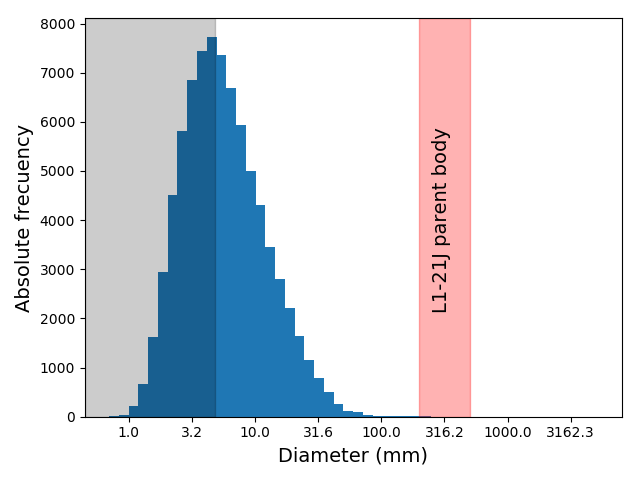

In [19]:
fig,axs=plt.subplots(1,1)

ax=axs
ax.hist(np.log10(all_sporadic["D"]),bins=50)
ax.axvspan(np.log10(20),np.log10(50),color='r',alpha=0.3)
ax.text(np.log10(30),4000,"L1-21J parent body",
        rotation=90,fontsize=14,va='center',ha='center')

xl=[]
for x in ax.get_xticks():
    xl+=[f"{10*10**x:.1f}"]
ax.set_xticklabels(xl)

Dmin,Dmax=ax.get_xlim()
ax.axvspan(Dmin,np.log10(0.48),color='k',alpha=0.2)
ax.set_xlim(Dmin,Dmax)

#ax.set_title("CAMS 2010-2013 sporadic meteors size distribution")
ax.set_xlabel("Diameter (mm)",fontsize=14)
ax.set_ylabel("Absolute frecuency",fontsize=14)

fig.savefig(f"{IMPACT_FIGDIR}/l21j-sporadic-sizes.png")
fig.tight_layout()

We integrate this population to GRT and run a GRT analysis at the location of the [Freamont Peak observatory](https://en.wikipedia.org/wiki/Fremont_Peak_Observatory) one of the observing sites of CAMS, using as target population the sporadics.  If the analysis is correct, GRT must reconstruct the observed speed distribution 

In [20]:
suf="CAMS"
location="lat_3.67602e+01__lon_-1.21499e+02"
data_rays=np.loadtxt(f"{IMPACT_FIGDIR}/rays-{location}-{suf}.data.phys")
data_rays_prob=np.loadtxt(f"{IMPACT_FIGDIR}/rays-{location}-{suf}.data.prob")
Nrays=len(data_rays)
print(f"Number of test trajectories read: {Nrays}")
pprob=data_rays_prob[:,7]

Number of test trajectories read: 37875


Now we compute the moments of the speed

In [21]:
vimpobs=data_rays[:,2]
vmean=(vimpobs*pprob).sum()/pprob.sum()
vmin=vimpobs.min()
vmax=vimpobs.max()
print(f"Range of GRT speeds: {vmin}-{vmax}")

#Parameters of the moment calculation
vstd=0
vmax=72

ns=[1,2,3]
smoments=[]
error=0.1
for n in ns:
    if n==1:
        smoments+=[(1,(vimpobs*pprob).sum()/pprob.sum(),error)]
    else:
        smoments+=[(n,((vimpobs-vstd)**n*pprob).sum()/pprob.sum(),n*error)]
    print(f"Stride moment {n}: {smoments[-1][1]}")

Range of GRT speeds: 11.471-43.039
Stride moment 1: 16.240559313653375
Stride moment 2: 270.3869060843263
Stride moment 3: 4636.92829037359


Now we fit the moments to a theoretical curve:

In [22]:
params=[6e-2,15.0,0.5,1]
fitSMoments(params,vmin,vmax,vstd,smoments,True)

1: 5.9096797791916025 vs. 16.240559313653375 (dm = 0.1)
2: 105.65774683827158 vs. 270.3869060843263 (dm = 0.2)
3: 2038.5519163109916 vs. 4636.92829037359 (dm = 0.30000000000000004)


75706396.00802888

In [23]:
solution=minimize(fitSMoments,params,args=(vmin,vmax,vstd,smoments),
                  bounds=((1e-3,1),(vmin,vmax),(0.1,5),(0.1,5)))
print(solution)
params=solution.x
k,vo,a,b=params
fitSMoments(params,vmin,vmax,vstd,smoments,True)

/Users/jzuluaga/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:290: RuntimeWarning: divide by zero encountered in double_scalars


      fun: 0.5058712928386274
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-21267.48948137,  -1887.61759263,  -4263.35796891,   3895.881522  ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2915
      nit: 257
   status: 0
  success: True
        x: array([ 0.11949685, 15.40498134,  0.88445196,  1.38367052])
1: 16.310499407882197 vs. 16.240559313653375 (dm = 0.1)
2: 270.36683338388747 vs. 270.3869060843263 (dm = 0.2)
3: 4636.903850439112 vs. 4636.92829037359 (dm = 0.30000000000000004)


0.5058712928386274

Median theoretical speed: 15.537423991636789
Median observed speed: 17.07
Mean theoretical speed: 16.310499407882197
Mean observed speed: 18.76263967611334


<IPython.core.display.Javascript object>


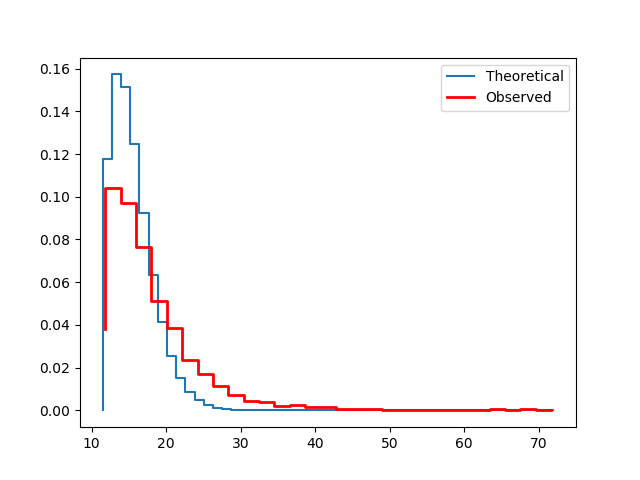

In [24]:
k,vo,a,b=params
vm=ptheoMean(vmin,vmax,k,vo,a,b)
norm=ptheoNorm(vmin,vmax,k,vo,a,b)
vmed=ptheoMedian(vmin,vmax,k,vo,a,b,1,norm)
print("Median theoretical speed:",vmed)
print("Median observed speed:",sporadic["V inf"].median())
print("Mean theoretical speed:",vm)
print("Mean observed speed:",sporadic["V inf"].mean())
fig=plt.figure()
ax=fig.gca()

#Observed speed distribution
bins=30
hvs,vs=np.histogram(sporadic["V inf"],density=True,bins=bins)
vms=(vs[:-1]+vs[1:])/2

vss=np.linspace(vmin,vmax)
ax.step(vss,ptheo(vss,vmin,k,vo,a,b),label="Theoretical")
ax.step(vms,hvs,color='r',lw=2,label="Observed")

ax.legend()

Conclusion: GRT is unable to capture the largest velocities.  This is probably due to resolution effects.  Still 

### Method applied to the Moon

Now that we have tested the method we will apply it to the Moon

In [25]:
data_rays=np.loadtxt(f"{IMPACT_FIGDIR}/rays-{IMPACT_SUFFIX}-{tpop}.data.phys")
data_rays_prob=np.loadtxt(f"{IMPACT_FIGDIR}/rays-{IMPACT_SUFFIX}-{tpop}.data.prob")
Nrays=len(data_rays)
print(f"Number of test trajectories read: {Nrays}")
pprob=data_rays_prob[:,7]

#Moments
vimpobs=data_rays[:,2]
vmean=(vimpobs*pprob).sum()/pprob.sum()
vmin=vimpobs.min()
vmax=vimpobs.max()
print(f"Range of GRT speeds: {vmin}-{vmax}")

#Parameters of the moment calculation
vstd=0
vmax=72

ns=[1,2,3]
smoments=[]
error=0.1
for n in ns:
    if n==1:
        smoments+=[(1,(vimpobs*pprob).sum()/pprob.sum(),error)]
    else:
        smoments+=[(n,((vimpobs-vstd)**n*pprob).sum()/pprob.sum(),n*error)]
    print(f"Stride moment {n}: {smoments[-1][1]}")

Number of test trajectories read: 41167
Range of GRT speeds: 2.7972-44.058
Stride moment 1: 15.128444683530716
Stride moment 2: 260.587671255224
Stride moment 3: 5069.386133327644


In [26]:
params=[5e-2,15.0,0.5,3]
fitSMoments(params,vmin,vmax,vstd,smoments,True)

1: 13.308478431800289 vs. 15.128444683530716 (dm = 0.1)
2: 162.74636632766396 vs. 260.587671255224 (dm = 0.2)
3: 2224.9662000868625 vs. 5069.386133327644 (dm = 0.30000000000000004)


90136595.99165824

In [27]:
solution=minimize(fitSMoments,params,args=(vmin,vmax,vstd,smoments),
                  bounds=((1e-3,1),(vmin,vmax),(0.1,5),(0.1,5.0)))
print(solution)
params=solution.x
k,vo,a,b=params
fitSMoments(params,vmin,vmax,vstd,smoments,True)

      fun: 1.415780902638311
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-264292.18420905,    -897.4396376 ,   -9868.81792975,
          1523.22423068])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 550
      nit: 59
   status: 0
  success: True
        x: array([1.22507998e-02, 1.96034067e+01, 8.08839527e-01, 2.74234668e+00])
1: 15.011936497319393 vs. 15.128444683530716 (dm = 0.1)
2: 260.6307897141176 vs. 260.587671255224 (dm = 0.2)
3: 5069.353427658714 vs. 5069.386133327644 (dm = 0.30000000000000004)


1.415780902638311

<IPython.core.display.Javascript object>


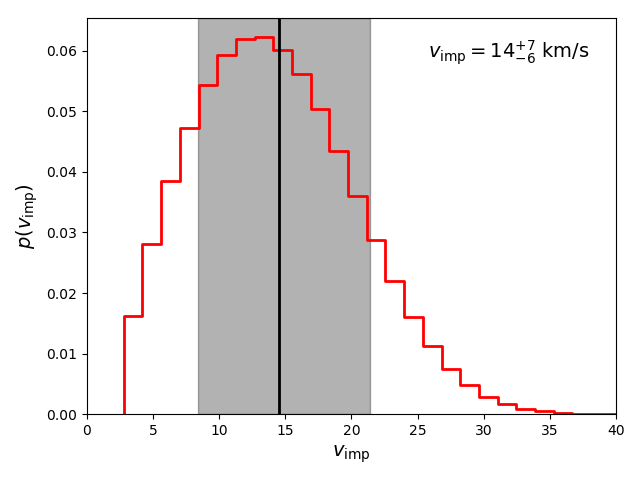

In [28]:
fig=plt.figure()
ax=fig.gca()

k,vo,a,b=solution.x
vimps=np.linspace(vmin,vmax)
pvs=ptheo(vimps,vmin,k,vo,a,b)
ax.step(vimps,pvs,color='r',lw=2)
fname=f"{IMPACT_FIGDIR}/vimp-marginal-{tpop}.dat"
np.savetxt(fname,np.vstack((vimps,pvs)).transpose())

ax.set_xlabel(r"$v_{\rm imp}$",fontsize=14)
ax.set_ylabel(r"$p(v_{\rm imp})$",fontsize=14)

norm=ptheoNorm(vmin,vmax,k,vo,a,b)

v1=ptheoPercentile(vmin,vmax,k,vo,a,b,1,norm,0.15)
vm=ptheoPercentile(vmin,vmax,k,vo,a,b,1,norm,0.5)
v2=ptheoPercentile(vmin,vmax,k,vo,a,b,1,norm,0.85)
mv=v1-vm;pv=v2-vm

vimp=vm;dvimp_p=pv;dvimp_m=mv
ax.axvspan(v1,vm,color='k',alpha=0.3)
ax.axvline(vm,color='k',lw=2)
ax.axvspan(vm,v2,color='k',alpha=0.3)

ax.text(0.95,0.95,r"$v_{\rm imp}=%.0lf^{%+.0lf}_{%+.0lf}$ km/s"%(vm,pv,mv),
        transform=ax.transAxes,ha='right',va='top',fontsize=14)

ymin,ymax=ax.get_ylim()
ax.set_xlim((0,40))
ax.set_ylim((0,ymax))

fig.tight_layout()
fig.savefig(f"{IMPACT_FIGDIR}/l21j-vimp-ppd-{tpop}.png")

In [29]:
grt_properties=[
    dict(indice=0,property="elevation",factor=30),
    dict(indice=1,property="azimuth",factor=50)
]
for qprop in grt_properties:
    print(f"Computing ppd for {qprop['property']}")
    xs=data_rays[:,qprop["indice"]]
    xun=np.unique(xs)
    Nun=len(xun)
    print("\tUnique values of property:",Nun)

    # Range of elevations                                                                                                                                                                                                                                     
    xmin=xs.min()
    xmax=xs.max()
    print("\tRanges:",xmin,xmax)

    # Create boxes                                                                                                                                                                                                                                            
    Nb=int(Nun/qprop["factor"])
    print("\tSampling points:",Nb)
    xb=np.linspace(xmin,1.01*xmax,Nb,endpoint=False)
    dxb=xb[1]-xb[0]

    # Compute probabilities                                                                                                                                                                                                                                   
    P=0
    hb=np.zeros(Nb)
    for i,x in tqdm(enumerate(xs)):
        p=pprob[i]
        n=int((x-xmin)/dxb)
        if qprop["property"]=="elevation":
          xcen=(xmin+(n+1./2)*dxb)
          factor=1/np.cos(xcen*np.pi/180)
        else:
          factor=1
        P+=factor*p
        hb[n]+=factor*p

    hb=np.array(hb)
    hb/=P

    #Save histogram
    fname=f"{IMPACT_FIGDIR}/{qprop['property']}-marginal-{tpop}.dat"
    print(f"\tSaving {fname}")
    np.savetxt(fname,np.vstack((xb,hb)).transpose())

8384it [00:00, 83839.28it/s]

Computing ppd for elevation
	Unique values of property: 498
	Ranges: 0.27798 83.332
	Sampling points: 16


41167it [00:00, 85665.05it/s]
21152it [00:00, 211515.66it/s]

	Saving .//data/L1-21J/elevation-marginal-neos.dat
Computing ppd for azimuth
	Unique values of property: 498
	Ranges: 0.27282 359.06
	Sampling points: 9


41167it [00:00, 202703.04it/s]

	Saving .//data/L1-21J/azimuth-marginal-neos.dat


### Incident angle statistics

<IPython.core.display.Javascript object>


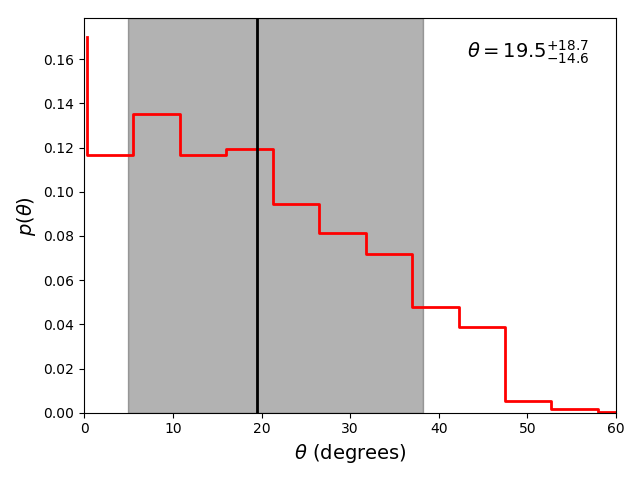

In [30]:
plt.ion()
#Posterior probability distribution of impact velocities
data=np.loadtxt(f"{IMPACT_FIGDIR}/elevation-marginal-{tpop}.dat")
angles=data[:,0]
pas=data[:,1]
v1,vm,v2=ipercs(angles,pas,[15.0,50.0,85.0])
mv=v1-vm;pv=v2-vm
thetamax=v2

#Figure
fig=plt.figure()
ax=fig.gca()

ax.step(angles,pas,color='r',lw=2)

ax.set_xlabel(r"$\theta$ (degrees)",fontsize=14)
ax.set_ylabel(r"$p(\theta)$",fontsize=14)

ax.axvspan(v1,vm,color='k',alpha=0.3)
ax.axvline(vm,color='k',lw=2)
ax.axvspan(vm,v2,color='k',alpha=0.3)

ax.text(0.95,0.95,r"$\theta=%.1lf^{%+.1lf}_{%+.1lf}$"%(vm,pv,mv),
        transform=ax.transAxes,ha='right',va='top',fontsize=14)

ymin,ymax=ax.get_ylim()
ax.set_ylim((0,ymax))
ax.set_xlim((0,60))

fig.tight_layout()
fig.savefig(f"{IMPACT_FIGDIR}/l21j-elevation-ppd-{tpop}.png")

### Distribution of Radiants

In [31]:
#Build 2D histogram
RAmin=0.0;RAmax=360;NRA=20;dRA=(RAmax-RAmin)/NRA
DECmin=-90.0;DECmax=90.0;NDEC=20;dDEC=(DECmax-DECmin)/NDEC

#Run over all combinations
hrd=np.zeros((NDEC,NRA))
pprob=data_rays_prob[:,7]

j=0
P=0
for i in tqdm(range(len(data_rays))):

    #Topocentric coordinates
    Az=data_rays[i,1]
    h=data_rays[i,0]
    p=pprob[i]

    #J2000 coordinates
    RA,DEC=loc2Sky(IMPACT_ET,Az,h,
                   IMPACT_LOC["lon"],IMPACT_LOC["lat"],IMPACT_LOC["alt"],
                   "MOON","IAU_MOON")
    #print(Az,h,RA/15,DEC)
    
    nRA=int((RA-RAmin)/dRA)
    nDEC=int((DEC-DECmin)/dDEC)

    if nRA>=NRA or nDEC>=NDEC:continue
        
    DEC=DECmin+(nDEC+0.5)*dDEC
    factor=1/np.cos(DEC*np.pi/180)
    
    P+=factor*p
    hrd[nDEC,nRA]+=factor*p
    j+=1
hrd/=P

100%|██████████| 41167/41167 [00:15<00:00, 2598.48it/s]


In [32]:
#Surface of the moon
sRA=[]
sDEC=[]
h=0
for Az in np.linspace(0,360,100):
    RA,DEC=loc2Sky(IMPACT_ET,Az,h,IMPACT_LOC["lon"],IMPACT_LOC["lat"],IMPACT_LOC["alt"],
                   "MOON","IAU_MOON")
    sRA+=[RA]
    sDEC+=[DEC]
sRA=np.array(sRA);sDEC=np.array(sDEC)

<IPython.core.display.Javascript object>


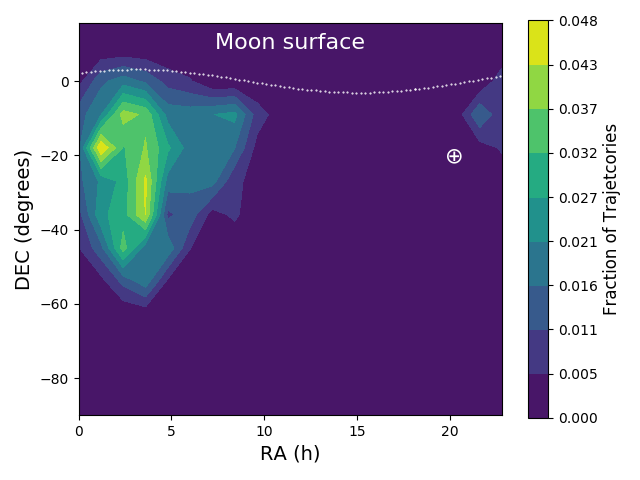

In [33]:
#Map
RAs,DECs=np.meshgrid(np.arange(RAmin,RAmax,dRA),np.arange(DECmin,DECmax,dDEC))
hrd/=hrd.sum()
hmin=hrd.min();hmax=hrd.max()

fig=plt.figure()
ax=fig.gca()

c=ax.contourf(RAs/15.0,DECs,hrd,levels=np.linspace(hrd.min(),hrd.max(),10)) #,cmap="YlOrBr")
cbar=fig.colorbar(c)
cbar.ax.set_ylabel('Fraction of Trajetcories',fontsize=12)

ytl=[]
for y in cbar.ax.get_yticks():
    ytl+=["%.3f"%(hmin+y*(hmax-hmin))]
cbar.ax.set_yticklabels(ytl)

#ax.plot(RA_EARTH,DEC_EARTH,'wo')
ax.plot(sRA/15.0,sDEC,'w.',ms=1)

ax.set_ylim((-90.0,5*max(sDEC)))
ax.set_xlim((0,RAs.max()/15.0))

ax.text(RA_EARTH,DEC_EARTH,r'$\oplus$',ha='center',va='center',color='w',fontsize=16)
ax.text(0.5,0.95,"Moon surface",ha='center',va='center',transform=ax.transAxes,color='w',fontsize=16)

ax.set_xlabel("RA (h)",fontsize=14)
ax.set_ylabel("DEC (degrees)",fontsize=14)

ax.set_aspect(0.2)
fig.tight_layout()
fig.savefig(f"{IMPACT_FIGDIR}/l21j-RA_DEC-map-{tpop}.png")

In [34]:
#Identify maxima
#"""
#NEOs
if tpop=="neos":
    RArad=3.07
    DECrad=-23.7
if tpop=="alt":
    #Sporadic
    RArad=1.2
    DECrad=-17.8
print(f"Radiant: (RA,DEC) = {RArad}, {DECrad}")

Radiant: (RA,DEC) = 3.07, -23.7


### Orbital Map

In [35]:
amin=0.5;amax=2.5;Na=10;da=(amax-amin)/Na
emin=0.0;emax=1.0;Ne=10;de=(emax-emin)/Ne

hae=np.zeros((Na,Ne))
for i in tqdm(range(Nrays)):
    q=data_rays[i,9]
    e=data_rays[i,10]
    if e>=1:continue
    a=q/(1-e)
    na=int((a-amin)/da)
    ne=int((e-emin)/de)
    if na>=Na or ne>=Ne:continue
    hae[ne,na]+=1
Nt=hae.sum()

100%|██████████| 41167/41167 [00:00<00:00, 162576.60it/s]


<IPython.core.display.Javascript object>


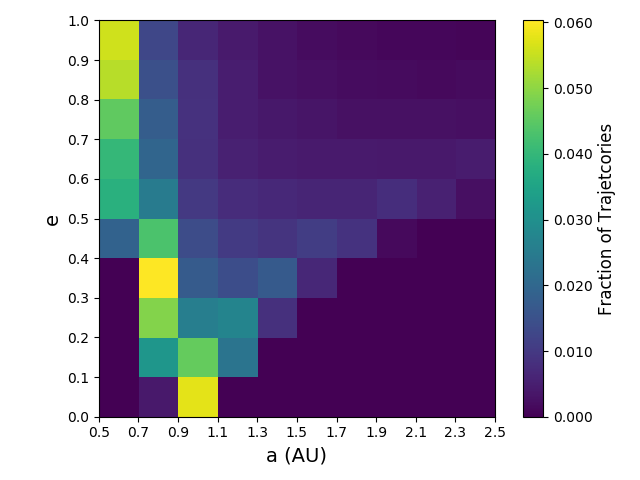

In [36]:
#Figure
hmin=hae.min()/Nt;hmax=hae.max()/Nt

A,E=np.meshgrid(np.arange(amin,amax,da),np.arange(emin,emax,de))
fig=plt.figure()
ax=fig.gca()

im=ax.imshow(hae/Nt,origin='lower')
cbar=fig.colorbar(im)
cbar.ax.set_ylabel('Fraction of Trajetcories',fontsize=12)

ytl=[]
for y in cbar.ax.get_yticks():
    ytl+=["%.3f"%(hmin+y*(hmax-hmin))]
cbar.ax.set_yticklabels(ytl)


ax.set_xlabel("a (AU)",fontsize=14)
ax.set_ylabel("e",fontsize=14)

xts=[]
xtl=[]
for i in np.arange(0.0,Na+1,1):
    xts+=[i-0.5]
    xtl+=["%.1f"%(amin+i*da)]
t=ax.set_xticks(xts)
t=ax.set_xticklabels(xtl)

xts=[]
xtl=[]
for i in np.arange(0.0,Ne+1,1):
    xts+=[i-0.5]
    xtl+=["%.1f"%(emin+i*de)]
t=ax.set_yticks(xts)
t=ax.set_yticklabels(xtl)

fig.tight_layout()
fig.savefig(f"{IMPACT_FIGDIR}/l21j-ae-map-{tpop}.png")

## Photometry

### Magnitude calculations

#### G-Magnitude

In [37]:
Gts=[]
dGts=[]
texps=[]
for key,site in sites.items():

    print(f"Fitting photometry for site {key}:")
    
    #Extract photometric data
    stars=site["data"]
    impact=stars.loc[stars["ObjName"]=="L1-21J"].iloc[0]
    stars=stars.loc[stars["type"]=="Star"]
    texps+=[site["texp"]]

    #Minimize
    coefs=deepcopy(PHOTOMETRY_COEFS)
    solution=minimize(chiSquare,coefs,args=(stars,False),tol=1e-5)

    #Test Solution
    chisq,dGs=chiSquare(solution.x,stars,verbose=True)
    dG=np.sqrt(np.mean(np.array(dGs)**2))
    print(f"\tRMS magnitude fit error:{dG}")
    
    #Determine the magnitude of the simpact
    Gt=Gmag(solution.x,impact["CountsR"],impact["CountsG"],impact["CountsB"])
    dGt=deltaGmag(solution.x,impact["CountsR"],impact["CountsG"],impact["CountsB"])
    dG=np.sqrt(dG**2++dGt**2)
    print(f"\tPoisson error: {dGt}")
    print(f"\tMagnitude without exposure correction:",Gt)
    print(f"\tError:",dG)
    Gts+=[Gt]
    dGts+=[dG]
    
    site["Gt"]=Gt
    site["dG"]=dG
    impact.loc["G"]=Gt

Fitting photometry for site RD:
BD+21 1766:Teo=8.332326935276292,Obs=8.3523,dM=0.019973064723707523
BD+20 2007:Teo=9.716401243841592,Obs=9.7906,dM=0.07419875615840787
HD 67564:Teo=9.214110841358224,Obs=9.0181,dM=0.19601084135822333
TYC 1385-899-1:Teo=10.096088322435435,Obs=10.0132,dM=0.08288832243543531
BD+21 1779:Teo=8.862222440980187,Obs=8.9471,dM=0.08487755901981409
BD+21 1777:Teo=9.5698938006629,Obs=9.6792,dM=0.10930619933709984
BD+20 2009:Teo=10.34659999263705,Obs=10.4423,dM=0.09570000736295015
BD+20 2005:Teo=8.665190381334455,Obs=8.6293,dM=0.03589038133445399
TYC 1385-939-1:Teo=10.421865975179573,Obs=10.3526,dM=0.06926597517957234
	RMS magnitude fit error:0.09752010282437712
	Poisson error: 0.14747368585035264
	Magnitude without exposure correction: 11.682978318448377
	Error: 0.1768011834608739
Fitting photometry for site Georgia:
TYC 1385-116-1:Teo=10.55747389086084,Obs=10.5824,dM=0.0249261091391606
HD 68121:Teo=9.56017838210927,Obs=9.5567,dM=0.003478382109269873
TYC 1385-1052-1

In [38]:
Vts=[]
dVts=[]
texps=[]
for key,site in sites.items():

    print(f"Fitting photometry for site {key}:")
    
    #Extract photometric data
    stars=site["data"]
    impact=stars.loc[stars["ObjName"]=="L1-21J"].iloc[0]
    stars=stars.loc[stars["type"]=="Star"]
    texps+=[site["texp"]]

    #Minimize
    coefs=deepcopy(PHOTOMETRY_COEFS)
    solution=minimize(chiSquareV,coefs,args=(stars,False),tol=1e-5)

    #Test Solution
    chisq,dVs=chiSquareV(solution.x,stars,verbose=True)
    dV=np.sqrt(np.mean(np.array(dVs)**2))
    print(f"\tRMS magnitude fit error:{dV}")
    
    #Determine the magnitude of the simpact
    Vt=Gmag(solution.x,impact["CountsR"],impact["CountsG"],impact["CountsB"])
    dVt=deltaGmag(solution.x,impact["CountsR"],impact["CountsG"],impact["CountsB"])
    dV=np.sqrt(dV**2+dVt**2)
    print(f"\tPoisson error: {dVt}")
    print(f"\tMagnitude without exposure correction:",Vt)
    print(f"\tError:",dV)
    Vts+=[Vt]
    dVts+=[dV]
    
    site["Vt"]=Vt
    site["dV"]=dV
    impact.loc["V"]=Vt

Fitting photometry for site RD:
BD+21 1766:Teo=8.95076824039771,Obs=9.03,dM=0.07923175960228868
BD+20 2007:Teo=9.826672731092419,Obs=9.82,dM=0.006672731092418616
HD 67564:Teo=9.317153518616845,Obs=9.09,dM=0.22715351861684496
TYC 1385-899-1:Teo=10.327199717544753,Obs=10.22,dM=0.1071997175447521
BD+21 1779:Teo=9.19686297113522,Obs=9.22,dM=0.023137028864780973
BD+21 1777:Teo=9.892728051214464,Obs=10.18,dM=0.28727194878553597
BD+20 2009:Teo=10.332473843509035,Obs=10.52,dM=0.18752615649096427
BD+20 2005:Teo=9.123410998118521,Obs=9.04,dM=0.08341099811852182
TYC 1385-939-1:Teo=10.812729859628199,Obs=10.66,dM=0.15272985962819874
	RMS magnitude fit error:0.15560743205357613
	Poisson error: 0.0838632026368539
	Magnitude without exposure correction: 11.729254167647825
	Error: 0.1767673885840325
Fitting photometry for site Georgia:
TYC 1385-116-1:Teo=10.949636610442589,Obs=10.81,dM=0.13963661044258835
HD 68121:Teo=9.635025184584885,Obs=9.64,dM=0.004974815415115685
TYC 1385-1052-1:Teo=10.4891144711

### Intercept calculation

#### First attempt using fitting and poisson errors only

In [39]:
photofitparam=[6.0]
solution=minimize(photoFit,photofitparam,args=(texps,Gts,dGts))
Go=solution.x[0]
fun=solution.fun
dGo=errorMagnitude(Go,fun,1,Gts,dGts)
print(f"Best fitted magnitude: {Go}+/-{dGo}")

Best fitted magnitude: 6.604119312934371+/-0.08650491095067991


In [40]:
chisq,es=photoFit(solution.x,texps,Gts,dGts,verbose=True)
dres=np.sqrt((es*np.array(dGts)**2).mean())
print(f"RMS of the residuals: {dres}")

RMS of the residuals: 0.4273523989544647


#### Second attempt after correcting errors with fitting line residual

In [41]:
dGts=np.array(dGts)
dGtes=[np.sqrt(dGt**2+dres**2) for dGt in dGts]

In [42]:
photofitparam=[6.0]
solution=minimize(photoFit,photofitparam,args=(texps,Gts,dGtes))
Go=solution.x[0]
fun=solution.fun
dGo=errorMagnitude(Go,fun,1,Gts,dGtes)
print(f"Best fitted magnitude: {Go}+/-{dGo}")

Best fitted magnitude: 6.676213893119444+/-0.34520408274147485


In [43]:
i=0
for key,site in sites.items():
    site["dG"]=dGtes[i]
    i+=1

<IPython.core.display.Javascript object>


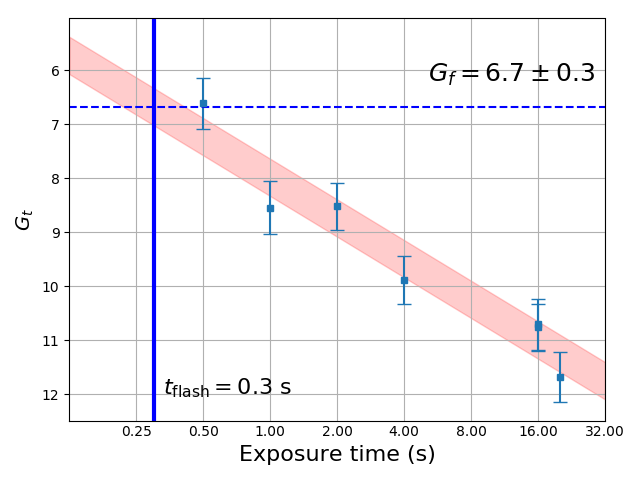

In [44]:
plt.ion()
fig=plt.figure()
ax=fig.gca()

tmin=0.125
tmax=32.0
ts=np.linspace(tmin,tmax,10)

ax.errorbar(texps,Gts,yerr=dGtes,ls='',fmt='s',ms=4,capsize=5)
ax.fill_between(ts,
               (Go+dGo)-2.5*np.log10(IMPACT_FLASH/ts),
               (Go-dGo)-2.5*np.log10(IMPACT_FLASH/ts),
               color='red',alpha=0.2)

ax.set_xscale("log")

ax.set_xlabel("Exposure time (s)",fontsize=16)
ax.set_ylabel("$G_t$",fontsize=14)

ax.axvline(IMPACT_FLASH,lw=3,color='b')
ax.axhline(Go,ls='--',color='b')

ax.set_xlim((tmin,tmax))
ax.text(1.1*0.3,12,r"$t_{\rm flash}=0.3$ s",fontsize=16,ha='left')
ax.text(0.9*tmax,Go-dGo,f"$G_f={Go:.1f}\pm{dGo:.1f}$",ha='right',va='bottom',fontsize=18)

ax.set_xticks([0.25,0.5,1.0,2.0,4.0,8.0,16.0,32.0])
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_tick_params(which='major', size=0)
ax.get_xaxis().set_tick_params(which='major', width=0) 
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.invert_yaxis()
ax.grid()

fig.tight_layout()
fig.savefig(f"{IMPACT_FIGDIR}/l21j-Gmag-time.png")

#### V magnitude

Best fitted magnitude: 7.100689684330814+/-0.09239392082781706
RMS of the residuals: 0.2625237908441249
Best fitted magnitude (second attempt): 7.096912852092025+/-0.22788977747586614


<IPython.core.display.Javascript object>


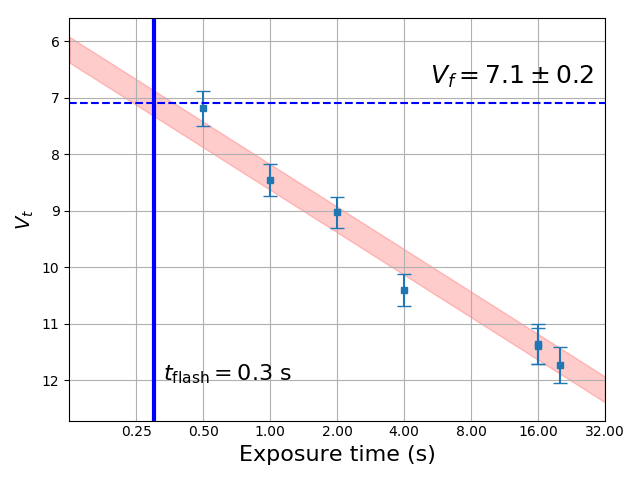

In [45]:
photofitparam=[6.0]
solution=minimize(photoFit,photofitparam,args=(texps,Vts,dVts))
Vo=solution.x[0]
fun=solution.fun
dVo=errorMagnitude(Vo,fun,1,Vts,dVts)
print(f"Best fitted magnitude: {Vo}+/-{dVo}")
chisq,es=photoFit(solution.x,texps,Vts,dVts,verbose=True)
dres=np.sqrt((es*np.array(dVts)**2).mean())
print(f"RMS of the residuals: {dres}")
dVts=np.array(dVts)
dVtes=[np.sqrt(dVt**2+dres**2) for dVt in dVts]
photofitparam=[6.0]
solution=minimize(photoFit,photofitparam,args=(texps,Vts,dVtes))
Vo=solution.x[0]
fun=solution.fun
dVo=errorMagnitude(Vo,fun,1,Vts,dVtes)
print(f"Best fitted magnitude (second attempt): {Vo}+/-{dVo}")
i=0
for key,site in sites.items():
    site["dV"]=dVtes[i]
    i+=1
plt.ion()
fig=plt.figure()
ax=fig.gca()

tmin=0.125
tmax=32.0
ts=np.linspace(tmin,tmax,10)

ax.errorbar(texps,Vts,yerr=dVtes,ls='',fmt='s',ms=4,capsize=5)
ax.fill_between(ts,
               (Vo+dVo)-2.5*np.log10(IMPACT_FLASH/ts),
               (Vo-dVo)-2.5*np.log10(IMPACT_FLASH/ts),
               color='red',alpha=0.2)

ax.set_xscale("log")

ax.set_xlabel("Exposure time (s)",fontsize=16)
ax.set_ylabel("$V_t$",fontsize=14)

ax.axvline(IMPACT_FLASH,lw=3,color='b')
ax.axhline(Vo,ls='--',color='b')

ax.set_xlim((tmin,tmax))
ax.text(1.1*0.3,12,r"$t_{\rm flash}=0.3$ s",fontsize=16,ha='left')
ax.text(0.9*tmax,Vo-dVo,f"$V_f={Vo:.1f}\pm{dVo:.1f}$",ha='right',va='bottom',fontsize=18)

ax.set_xticks([0.25,0.5,1.0,2.0,4.0,8.0,16.0,32.0])
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_tick_params(which='major', size=0)
ax.get_xaxis().set_tick_params(which='major', width=0) 
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.invert_yaxis()
ax.grid()

Vf=Vo
dVf=dVo

fig.tight_layout()
fig.savefig(f"{IMPACT_FIGDIR}/l21j-Vmag-time.png")

## Light curve toy-model

### Read data from Madiedo et al. (2019)

In [46]:
madiedo=pd.read_csv(f"{IMPACT_FIGDIR}/madiedo-lightcurve.csv")
madiedo["B"]=10**(-madiedo["V"]/2.5)
tini=madiedo["t"].iloc[0]
tend=madiedo["t"].iloc[-1]

#interpolate
Bfunc=interpolate(madiedo["t"],madiedo["B"],kind="slinear")
Vfunc=interpolate(madiedo["t"],madiedo["V"],kind="slinear")
ts=np.linspace(tini,tend,100)
Bs=Bfunc(ts)
Vs=Vfunc(ts)

#Average
Bint,err=integrate(Bfunc,tini,tend)
Bavg=Bint/(tend-tini)
mavg=-2.5*np.log10(Bavg)
print(f"Average brightness: {Bavg:e} (corresponding mag.: {mavg:g})")

Average brightness: 4.082028e-03 (corresponding mag.: 5.97281)


/Users/jzuluaga/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


<IPython.core.display.Javascript object>


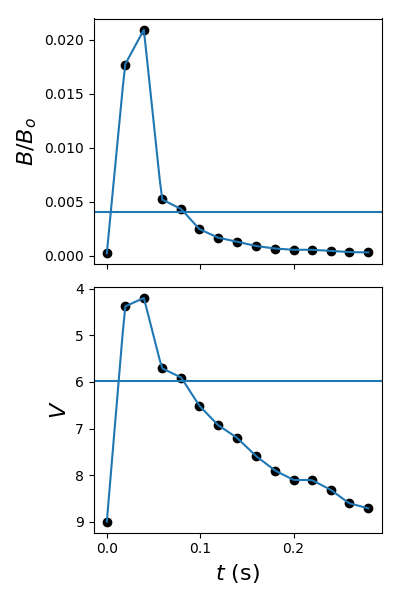

In [47]:
fig,axs=plt.subplots(2,1,sharex=True,figsize=(4,6))

axs[0].plot(madiedo["t"],madiedo["B"],'ko')
axs[0].plot(ts,Bs)
axs[0].axhline(Bavg)
axs[0].set_ylabel("$B/B_o$",fontsize=16)

axs[1].plot(madiedo["t"],madiedo["V"],'ko')
axs[1].plot(ts,Vs)
axs[1].axhline(mavg)
axs[1].set_ylabel("$V$",fontsize=16)

axs[1].set_xlabel("$t$ (s)",fontsize=16)
axs[1].invert_yaxis()

fig.tight_layout()

### Model

#### Origin of the model

<IPython.core.display.Javascript object>


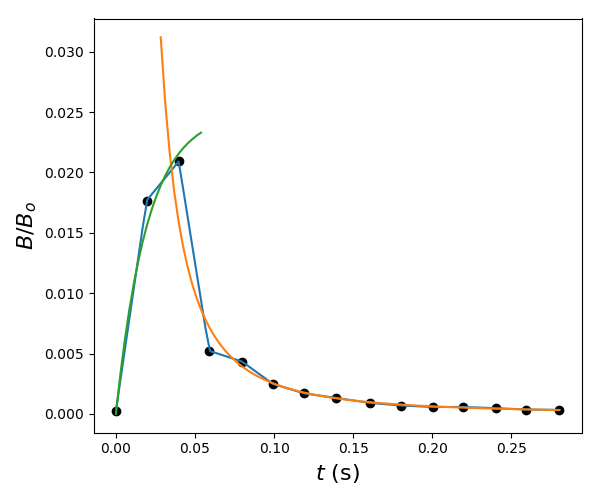

In [48]:
fig,axs=plt.subplots(1,1,figsize=(6,5))

axs.plot(madiedo["t"],madiedo["B"],'ko')
axs.plot(ts,Bs)
iini=10
axs.plot(ts[iini:],(5e-3/ts[iini:])**2)
iini=20
axs.plot(ts[:iini],2.5e-2*(1-np.exp(-ts[:iini]/0.02)))
axs.set_xlabel("$t$ (s)",fontsize=16)
axs.set_ylabel("$B/B_o$",fontsize=16)

fig.tight_layout()

#### Routines

In [49]:
def Vdownp(t,Vd,a):
    return Vd+a*np.log10(t)

def Vup(t,Vo,tau):
    return Vo*(1-t/tau)

def Vint(t,Vo,tau,Vd,a):
    dV=Vup(t,Vo,tau)-Vdownp(t,Vd,a)
    return dV

def Vtheo(t,Vo,tau,Vd,a):
    tmax=bisect(Vint,1e-4,10,args=(Vo,tau,Vd,a))
    if t<tmax:
        V=Vup(t,Vo,tau)
    else:
        V=Vdownp(t,Vd,a)
    return V

def chiSquare(params,lightcurve,dV,
              Vmax_obs,dVmax_obs,T_obs,dT_obs):
    #Parameters
    Vo=params[0]
    tau=params[1]
    Vd=params[2]
    a=params[3]
    tmax=bisect(Vint,1e-4,10,args=(Vo,tau,Vd,a))
    Vmax=Vup(tmax,Vo,tau)
    T=10**((Vo-Vd)/a)
    chisq=0
    for ind in lightcurve.index:
        point=lightcurve.loc[ind]
        chisq+=(point["V"]-Vtheo(point["t"],Vo,tau,Vd,a))**2/dV**2
    chisq+=(Vmax-Vmax_obs)**2/dVmax_obs**2
    chisq+=(T-T_obs)**2/dT_obs**2
    return chisq

def durationFromV(V,A=2.1,c=-0.54):
    #Bouley et al. (2012)
    tdur=A*np.exp(c*V)
    return tdur

### Fit Madiedo et al. (2019) light-curve

In [50]:
#Duration
T_obs=0.28
dT_obs=0.02
#Peak magnitude
Vmax_obs=4.2
dVmax_obs=0.5
#Time of peak magnitude
tmax=0.03
#Error in magnitude
dV=0.4

In [51]:
Vo=8.7;Vo_bnd=(8.7,9.5)
tau=0.05;tau_bnd=(0.05,0.08)
Vd=11.3;Vd_bnd=(10.0,12.0)
a=4.74;a_bnd=(3.0,6.0)

In [52]:
solution=minimize(chiSquare,[Vo,tau,Vd,a],
                  args=(madiedo,dV,Vmax_obs,dVmax_obs,T_obs,dT_obs),
                  bounds=(Vo_bnd,tau_bnd,Vd_bnd,a_bnd))
Vo,tau,Vd,a=solution.x
solution

      fun: 8.507364144224594
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.94944310e+00,  7.09049025e+02, -3.84581256e-04, -3.50297569e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 145
      nit: 10
   status: 0
  success: True
        x: array([ 8.7       ,  0.05      , 11.41257969,  4.8812413 ])

In [53]:
f=1
tmax=bisect(Vint,1e-4,10,args=(Vo,tau,Vd,f*a))
Vmax=Vup(tmax,Vo,tau)
T=10**((Vo-Vd)/(f*a))
print(f"tmax = {tmax}, Vmax = {Vmax}, T = {T}")

tmax = 0.02798084647821551, Vmax = 3.831332712790501, T = 0.2781537130260474


In [54]:
#Average magnitude
tmax=bisect(Vint,1e-4,10,args=(Vo,tau,Vd,a))
Vmax=Vup(tmax,Vo,tau)
T=10**((Vo-Vd)/a)
T=0.3
B=lambda t:10**(-Vtheo(t,Vo,tau,Vd,a)/2.5)
Vavg=-2.5*np.log10(integrate(B,0,T)[0]/T)
print(f"Average magnitude for Madiedo et al. (2019): {Vavg:.2f} +/- {dV}$")

Average magnitude for Madiedo et al. (2019): 6.25 +/- 0.4$


<IPython.core.display.Javascript object>


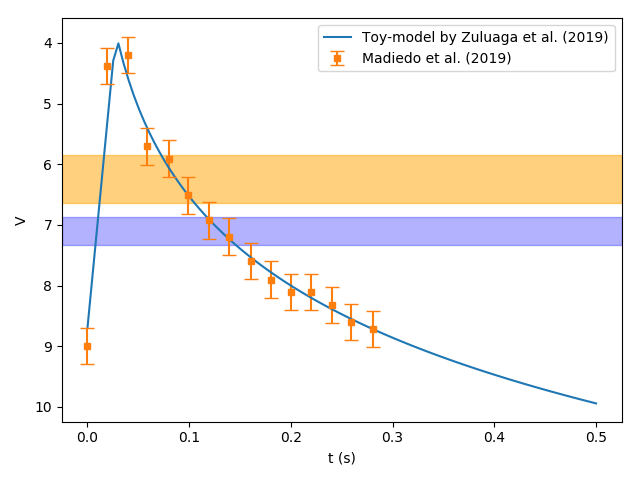

In [55]:
fig=plt.figure()
ax=fig.gca()

tes=np.linspace(1e-4,0.5,100)
Vis=np.array([Vtheo(t,Vo,tau,Vd,a) for t in tes])

ax.plot(tes,Vis,label="Toy-model by Zuluaga et al. (2019)")
ax.errorbar(madiedo["t"],madiedo["V"],yerr=0.3,ls='',fmt='s',ms=4,capsize=5,label='Madiedo et al. (2019)')

ax.axhspan(Vavg-dV,Vavg+dV,color='orange',alpha=0.5)
ax.axhspan(Vf-dVf,Vf+dVf,color='b',alpha=0.3)

ax.set_xlabel("t (s)")
ax.set_ylabel("V")
ax.legend()

ax.invert_yaxis()
fig.tight_layout()
fig.savefig(f"{IMPACT_FIGDIR}/l21j-lightcurve-toymodel.png")

#### Family of sample light curves

<IPython.core.display.Javascript object>


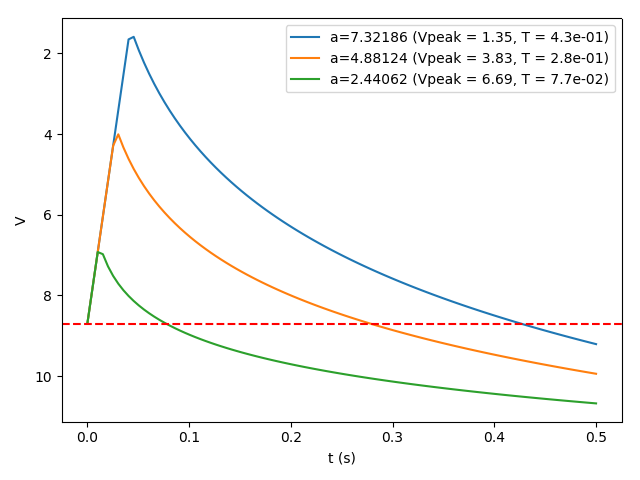

In [56]:
fig=plt.figure()
ax=fig.gca()

tes=np.linspace(1e-4,0.5,100)

f=1.5
tmax=bisect(Vint,1e-4,10,args=(Vo,tau,Vd,f*a))
Vmax=Vup(tmax,Vo,tau)
T=10**((Vo-Vd)/(f*a))
Vis=np.array([Vtheo(t,Vo,tau,Vd,f*a) for t in tes])
ax.plot(tes,Vis,label=f"a={f*a:g} (Vpeak = {Vmax:.2f}, T = {T:.1e})")
f=1.0
tmax=bisect(Vint,1e-4,10,args=(Vo,tau,Vd,f*a))
Vmax=Vup(tmax,Vo,tau)
T=10**((Vo-Vd)/(f*a))
Vis=np.array([Vtheo(t,Vo,tau,Vd,f*a) for t in tes])
ax.plot(tes,Vis,label=f"a={f*a:g} (Vpeak = {Vmax:.2f}, T = {T:.1e})")
f=0.5
tmax=bisect(Vint,1e-4,10,args=(Vo,tau,Vd,f*a))
Vmax=Vup(tmax,Vo,tau)
T=10**((Vo-Vd)/(f*a))
Vis=np.array([Vtheo(t,Vo,tau,Vd,f*a) for t in tes])
ax.plot(tes,Vis,label=f"a={f*a:g} (Vpeak = {Vmax:.2f}, T = {T:.1e})")

ax.axhline(Vo,ls='--',color='r')

ax.invert_yaxis()
ax.set_xlabel("t (s)")
ax.set_ylabel("V")
ax.legend()
fig.tight_layout()

#### Peak-magnitude vs. Duration

In [57]:
aes=[]
Ves=[]
Tes=[]
for f in np.linspace(0.7,1.5,100):
    aes+=[f*a]
    tmax=bisect(Vint,1e-4,10,args=(Vo,tau,Vd,aes[-1]))
    Vmax=Vup(tmax,Vo,tau)
    if Vmax<3 or Vmax>5:continue
    T=10**((Vo-Vd)/(f*aes[-1]))
    Ves+=[Vmax]
    Tes+=[T]
Ves=np.array(Ves)
Tes=np.array(Tes)

<IPython.core.display.Javascript object>


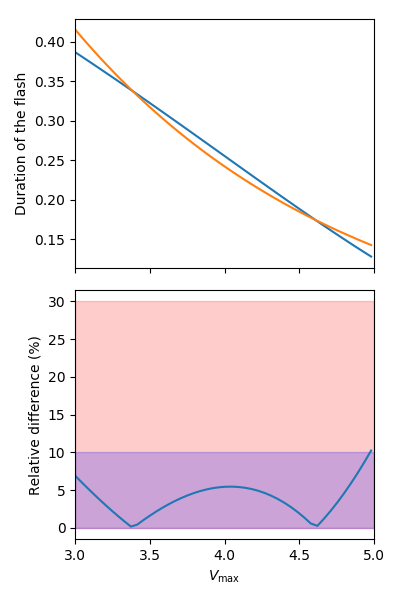

In [58]:
fig,axs=plt.subplots(2,1,sharex=True,figsize=(4,6))
ax=axs[0]
ax.plot(Ves,Tes)
ax.plot(Ves,durationFromV(Ves))
ax.set_ylabel("Duration of the flash")
ax=axs[1]
ax.plot(Ves,100*np.abs((Tes-durationFromV(Ves)))/durationFromV(Ves))
ax.set_ylabel("Relative difference (%)")
ax.set_xlabel(r"$V_{\rm max}$")
ax.axhspan(0,30,alpha=0.2,color='r')
ax.axhspan(0,10,alpha=0.2,color='b')

ax.set_xlim((3,5))
fig.tight_layout()

<IPython.core.display.Javascript object>


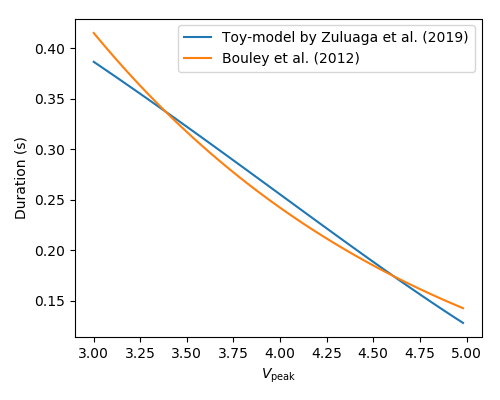

In [59]:
fig,axs=plt.subplots(1,1,sharex=True,figsize=(5,4))
ax=axs
ax.plot(Ves,Tes,label="Toy-model by Zuluaga et al. (2019)")
ax.plot(Ves,durationFromV(Ves),label="Bouley et al. (2012)")

ax.set_xlabel(r"$V_{\rm peak}$")
ax.set_ylabel("Duration (s)")

ax.legend()
fig.tight_layout()
fig.savefig(f"{IMPACT_FIGDIR}/l21j-DurationVpeak.png")

#### Average magnitude vs. Peak magnitude

In [60]:
Vmaxs=[]
Vavgs=[]
for f in np.linspace(0.7,1.5,20):
    aes+=[f*a]
    tmax=bisect(Vint,1e-4,10,args=(Vo,tau,Vd,aes[-1]))
    Vmax=Vup(tmax,Vo,tau)
    if Vmax<3 or Vmax>5:continue
    T=10**((Vo-Vd)/(f*aes[-1]))
    B=lambda t:10**(-Vtheo(t,Vo,tau,Vd,aes[-1])/2.5)
    Vavg=-2.5*np.log10(integrate(B,0,T)[0]/T)
    Vmaxs+=[Vmax]
    Vavgs+=[Vavg]

<IPython.core.display.Javascript object>


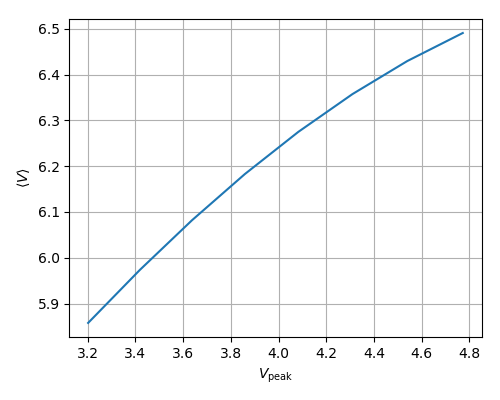

In [61]:
fig=plt.figure(figsize=(5,4))
ax=fig.gca()

ax.plot(Vmaxs,Vavgs)

ax.set_xlabel(r"$V_{\rm peak}$")
ax.set_ylabel(r"$\langle{V}\rangle$")
ax.grid()

fig.tight_layout()

## Energy of the impact

In [62]:
#Luminous energy
fany=2
Er=NG*10**((-Go+G0)/2.5)*DLAMBDA*fany*np.pi*(MOON_DISTANCE*1e3)**2*IMPACT_FLASH
logEr=np.log10(Er)
dlogEr=dGo/Go*logEr
print(f"Luminous energy (log): {logEr} +/- {dlogEr}")
#Kinetic energy
logK=logEr-logeta_mean
dlogK=np.sqrt(dlogEr**2+dlogeta**2)
print(f"Kinetic energy (log): {logK} +/- {dlogK}")
Kton_m=10**(logK-dlogK)/TTNT
Kton=10**logK/TTNT
Kton_p=10**(logK+dlogK)/TTNT
print(f"Range of kinetic energy in tons: {Kton_m}-{Kton_p} tons of TNT")

Luminous energy (log): 6.745524572813203 +/- 0.34878789985562253
Kinetic energy (log): 9.352148861740423 +/- 0.3751339688494536
Range of kinetic energy in tons: 0.2266852263780015-1.2755314015950312 tons of TNT


## Meteoroid and crater size

### Random values of primary quantities 

In [63]:
#Generate random values of the key quantities
N=1000
#Random kinetic energy
logKs=np.random.normal(logK,dlogK,N)
Ks=10**logKs
#Random impact speed
vrs=randomX(vimps,pvs,N)
#Random impact angle
thetas=randomX(angles,pas,N)
#Random densities
u=np.random.rand(N)
rhos=np.zeros(N)

RHO_COMET=1000
P_COMET=0.01
RHO_ROCKY=2500
P_ROCKY=0.59
RHO_METAL=3700
P_METAL=1-P_COMET-P_ROCKY

rhos[(u<0.01)]=RHO_COMET
rhos[(u>=0.01)*(u<0.59)]=RHO_ROCKY
rhos[(u>=0.59)]=RHO_METAL

### Derived quantities

In [64]:
#Mass
Ms=2*Ks/(vrs*1e3)**2
logMs=np.log10(Ms)
#Diameter
Ds=2*(3*Ms/(3*np.pi*rhos))**(1./3)
#Crater diameter
dcs=0.25*rhos**(1./6.)*RHO_REG**(-0.5)*Ks**0.29*(np.sin(thetas*DEG))**(1./3.)

In [65]:
#Basic statistics
print(f"Median impactor mass: {np.percentile(Ms,50)} kg")
print(f"Median impactor diameter: {np.percentile(Ds,50)} m")
print(f"Median crater size: {np.percentile(dcs,50)} m")

Median impactor mass: 20.56561639915602 kg
Median impactor diameter: 0.2625660503327604 m
Median crater size: 7.9855275950130356 m


### Posterior probability distributions

Generating statistics of logMs...


/Users/jzuluaga/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


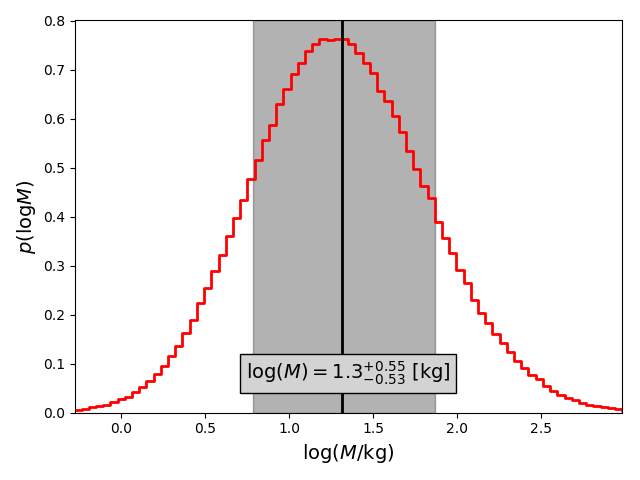

	Value: $\log(M)$$=1.3^{+0.55}_{-0.53}$ [kg]
	Creating figure file .//data/L1-21J/l21j-logMs-ppd-neos.png
Generating statistics of Ds...


<IPython.core.display.Javascript object>


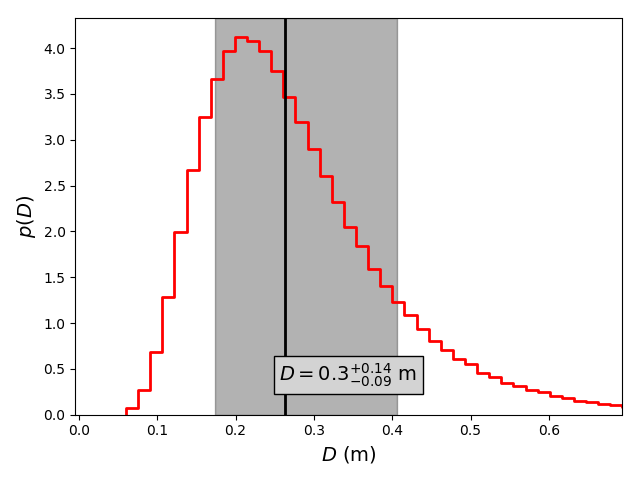

	Value: $D$$=0.3^{+0.14}_{-0.09}$ m
	Creating figure file .//data/L1-21J/l21j-Ds-ppd-neos.png
Generating statistics of dcs...


<IPython.core.display.Javascript object>


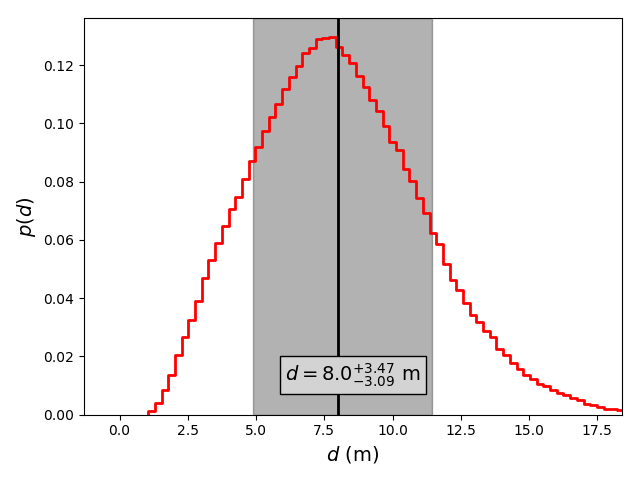

	Value: $d$$=8.0^{+3.47}_{-3.09}$ m
	Creating figure file .//data/L1-21J/l21j-dcs-ppd-neos.png


In [66]:
properties=[
    dict(name="$\log(M)$",units="[kg]",symbol="logMs",xlabel=r"$\log(M/{\rm kg})$",ylabel=r"$p(\log M)$"),
    dict(name="$D$",units="m",symbol="Ds",xlabel=r"$D$ (m)",ylabel=r"$p(D)$"),
    dict(name="$d$",units="m",symbol="dcs",xlabel=r"$d$ (m)",ylabel=r"$p(d)$"),
]
plt.ion()
for q in properties[:]:
    
    print(f"Generating statistics of {q['symbol']}...")
    
    #Statistics
    exec(f"vs=deepcopy({q['symbol']})")
    exec(f"hs,xs=np.histogram({q['symbol']},100,normed=True)")
    xms=(xs[1:]+xs[:-1])/2
    #Error
    x1,xm,x2=np.percentile(vs,[15,50,85])
    mv=xm-x1;pv=x2-xm
          
    if q["symbol"]=="logMs":
          logMs_val=xm
          dlogMs_m=x1-xm
          dlogMs_p=x2-xm
    elif q["symbol"]=="Ds":
          Ds_val=xm
          dDs_m=x1-xm
          dDs_p=x2-xm
    elif q["symbol"]=="dcs":
          dcs_val=xm
          ddcs_m=x1-xm
          ddcs_p=x2-xm

    #Plot distributions
    fig=plt.figure()
    ax=fig.gca()
    ax.step(xms,hs,color='r',lw=2)

    ax.set_xlabel(q["xlabel"],fontsize=14)
    ax.set_ylabel(q["ylabel"],fontsize=14)

    ax.axvspan(x1,xm,color='k',alpha=0.3)
    ax.axvline(xm,color='k',lw=2)
    ax.axvspan(xm,x2,color='k',alpha=0.3)

    value=r"%s$=%.1lf^{+%.2lf}_{-%.2f}$ %s"%(q["name"],xm,pv,mv,q["units"])
    print(f"\tValue: {value}")
    ax.text(0.5,0.1,value,
            transform=ax.transAxes,ha='center',va='center',fontsize=14,bbox=dict(facecolor='lightgray'))

    ymin,ymax=ax.get_ylim()
    ax.set_ylim((0,ymax))
    ax.set_xlim((x1-2*mv,x2+2*pv))
    fname=f"{IMPACT_FIGDIR}/l21j-{q['symbol']}-ppd-{tpop}.png"
    print(f"\tCreating figure file {fname}")
    fig.savefig(fname)
    fig.tight_layout()
    del(fig)


Mmin=10**(logMs_val+dlogMs_m)
Mmed=10**(logMs_val)
Mmax=10**(logMs_val+dlogMs_p)
Dmin=Ds_val+dDs_m
Dmed=Ds_val
Dmax=Ds_val+dDs_p
dmin=dcs_val+ddcs_m
dmed=dcs_val
dmax=dcs_val+ddcs_p

In [78]:
dmed

7.9855275950130356

## Generate paper content

### Macros

In [76]:
#First set of 
f=open(f"{IMPACT_FIGDIR}/macros-results-{tpop}.tex","w")

f.write("\\newcommand{\\vimpvalue}{%.0f^{%+.0f}_{%+.0f}} %s%%km/s\n"%(vimp,dvimp_p,dvimp_m,""))
f.write("\\newcommand{\\thetamax}{%.1f} %s%%deg\n"%(thetamax,""))
f.write("\\newcommand{\\Erel}{%s} %s%%log J\n"%(val2Exp(Er,fmt="%.0f",text=True),""))
f.write("\\newcommand{\\tflash}{%.1f} %s%%s \n"%(IMPACT_FLASH,""))
f.write("\\newcommand{\\Eimp}{%.1f-%.1f} %s%%tons of TNT\n"%(Kton_m,Kton_p,""))
f.write("\\newcommand{\\Emed}{%.1f} %s%%tons of TNT\n"%(Kton,""))
f.write("\\newcommand{\\Mrange}{%.0f-%.0f} %s%%kg\n"%(Mmin,Mmax,""))
f.write("\\newcommand{\\Drange}{%.0f-%.0f} %s%%cm\n"%(100*Dmin,100*Dmax,""))
f.write("\\newcommand{\\craterRange}{%.0f-%.0f} %s%%m\n"%(dmin,dmax,""))
f.write("\\newcommand{\\Mmed}{%.0f} %s%%kg\n"%(np.round(Mmed/10)*10,""))
f.write("\\newcommand{\\Dmed}{%.0f} %s%%cm\n"%(np.round(100*Dmed/10)*10,""))
f.write("\\newcommand{\\cratermed}{%.0f} %s%%m\n"%(np.round(dmed/10)*10,""))
f.write("\\newcommand{\\flashtime}{%s}%s\n"%(IMPACT_TIME,""))
f.write("\\newcommand{\\etarange}{%.3f-%.3f} %s%%adim.\n"%(np.floor(1000*eta_min)/1000,np.ceil(eta_max*1000)/1000,""))
f.write("\\newcommand{\\logeta}{%.1f\pm%.1f} %s%%log\n"%(logeta_mean,dlogeta,""))

#Position by visual inspection
f.write("\\newcommand{\\latvisual}{%.2f} %s%%deg\n"%(IMPACT_LOC["lat"],""))
f.write("\\newcommand{\\lonvisual}{%.2f} %s%%deg\n"%(IMPACT_LOC["lon"],""))

#Position by geometrical procedure
f.write("\\newcommand{\\latgeo}{%+.2f^{%+.2f}_{%+.2f}} %s%%deg\n"%(latGeo,dlatGeo_p,dlatGeo_m,""))
f.write("\\newcommand{\\longeo}{%+.2f^{%+.2f}_{%+.2f}} %s%%deg\n"%(lonGeo,dlonGeo_p,dlonGeo_m,""))

#Position by paralax
f.write("\\newcommand{\\latpar}{%.2f\pm 0.20} %s%%deg\n"%(Impact["slat"],""))
f.write("\\newcommand{\\lonpar}{%.2f\pm 0.08} %s%%deg\n"%(Impact["slon"],""))

#Radiant
f.write("\\newcommand{\\RArad}{%.1f} %s%%h\n"%(RArad,""))
f.write("\\newcommand{\\DECrad}{%.1f} %s%%deg\n"%(DECrad,""))

f.write("\\newcommand{\\Gf}{%.1f \pm %.1f} %s%%mag\n"%(Go,dGo,""))
f.write("\\newcommand{\\Vf}{%.1f \pm %.1f} %s%%mag\n"%(Vf,dVf,""))

#Energy estimation
f.write("\\newcommand{\\Moondist}{%g} %s%%km\n"%(MOON_DISTANCE,""))
f.write("\\newcommand{\\bG}{%s} %s%%bG\n"%(val2Exp(NG,fmt="%.1f",text=True),""))
f.write("\\newcommand{\\Go}{%g} %s%%G0\n"%(G0,""))
f.write("\\newcommand{\\deltaLambda}{%.3f} %s%%nm\n"%(DLAMBDA,""))
f.write("\\newcommand{\\fany}{%g} %s%%adim\n"%(fany,""))

#Result of the energy
f.write("\\newcommand{\\logEr}{%.1f\pm %.1f} %s%%logJ\n"%(logEr,dlogEr,""))
f.write("\\newcommand{\\logK}{%.1f\pm %.1f} %s%%logJ\n"%(logK,dlogK,""))
f.write("\\newcommand{\\rhoRegolith}{%g} %s%%g/cc\n"%(RHO_REG,""))
f.write("\\newcommand{\\rhoMin}{%g} %s%%g/cc\n"%(RHO_COMET,""))
f.write("\\newcommand{\\rhoMax}{%g} %s%%g/cc\n"%(RHO_METAL,""))
f.write("\\newcommand{\\rhoComet}{%g} %s%%g/cc\n"%(RHO_COMET,""))
f.write("\\newcommand{\\pComet}{%.1f} %s%%percentage\n"%(100*P_COMET,""))
f.write("\\newcommand{\\rhoRocky}{%g} %s%%g/cc\n"%(RHO_ROCKY,""))
f.write("\\newcommand{\\pRocky}{%.0f} %s%%percentage\n"%(100*P_ROCKY,""))
f.write("\\newcommand{\\rhoMetal}{%g} %s%%g/cc\n"%(RHO_METAL,""))
f.write("\\newcommand{\\pMetal}{%.0f} %s%%percentage\n"%(100*P_METAL,""))

#Geocentric position of the impact
f.write("\\newcommand{\\RAgeo}{%.5f} %s%%h\n"%(Impact["RAgeo"],""))
f.write("\\newcommand{\\DECgeo}{%.5f} %s%%deg\n"%(Impact["DECgeo"],""))
f.write("\\newcommand{\\Dimpgeo}{%.0f} %s%%km\n"%(Impact["Distance"]*REARTH,""))


#Geocentric position of the lunar center
f.write("\\newcommand{\\RAcen}{%.5f} %s%%h\n"%(Center["RAgeo"],""))
f.write("\\newcommand{\\DECcen}{%.5f} %s%%deg\n"%(Center["DECgeo"],""))
f.write("\\newcommand{\\Dcengeo}{%.0f} %s%%deg\n"%(Center["Distance"]*REARTH,""))

#NASA SPICE NAIF position
f.write("\\newcommand{\\RAcenNASA}{%.5f} %s%%h\n"%(RA_MOON,""))
f.write("\\newcommand{\\DECcenNASA}{%.5f} %s%%deg\n"%(DEC_MOON,""))
f.write("\\newcommand{\\DcenNASA}{%g} %s%%deg\n"%(MOON_DISTANCE,""))
        
f.close()

### Observations

In [68]:
#First set of 
f=open(f"{IMPACT_FIGDIR}/tab-observations.tex","w")

f.write("""%TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
%REFERENCE STARS TABLE
\\begin{table*}
\\centering
\\resizebox{\\textwidth}{!}{%
\\begin{tabular}{c|cc|rrr|rrr|rr}
\\hline\\hline
Star name & 
\\multicolumn{2}{c|}{Sky Position$^\\dagger$} & 
\\multicolumn{3}{c|}{Magnitudes} & 
\\multicolumn{3}{c|}{Counts (AP$^{\\dagger\\dagger}$)} & 
\\multicolumn{2}{c}{Coordinates}\\\\
 & RA & DEC & B & V & G$^\\ddagger$ & Red & Green & Blue & X & Y\\\\
\\hline
""")
for keys in ["RD","Georgia","CapeVerde","CanaryIslands"]:
    site=sites[keys]
    place=site["location"]
    data=site["data"]
    f.write("""
\\hline
\\multicolumn{11}{c}{%s}\\\\
\\hline
"""%place)
    for ind,star in data.loc[data["type"]=="Star"].iterrows():
        row=f"{star.ObjName} & "
        comment=""
        for field in "RA","DEC","B","V","G","CountsR","CountsG","CountsB","X","Y":
            value=star[field]
            if value==-1:
                value="-"
            if field=="RA" or field=="DEC":
                row+=f"{value:.5f}{comment} & "
            elif field=="X" or field=="Y":
                row+=f"{value:.0f}{comment} & "
            elif field=="B" or field=="V" or field=="G":
                row+=f"{value:.2f}{comment} & "
            else:
                row+=f"{value}{comment} & "
        row=row.strip(" & ")
        row+="\\\\\n"
        f.write(row)

    star=data.loc[data["ObjName"]=="L1-21J"].iloc[0]
    comment=""
    row=f"{star.ObjName} & "
    for field in "RA","DEC","B","V","G","CountsR","CountsG","CountsB","X","Y":
        value=star[field]
        if value==-1:
            value="-"
        if field=="RA" or field=="DEC":
            comment="*"
            row+=f"{value:.4f}{comment} & "
        elif field=="X" or field=="Y":
            row+=f"{value:.0f}{comment} & "
        else:
            comment=""
            row+=f"{value}{comment} & "
    row=row.strip(" & ")
    row+="\\\\\n"
    f.write(row)

f.write("""
\\hline
\\multicolumn{11}{c}{\\it Continues in Table \\ref{tab:referencestars2}}\\\\
\\hline\\hline
\\multicolumn{11}{l}{\\footnotesize $^\\ddagger$ J2000, $^\\ddagger$ Gaia G-magnitude, $^{\\dagger\\dagger}$ Aperture photometry}\\\\
\\multicolumn{11}{l}{\\footnotesize $^*$ Calculated coordinates (see Section \\ref{sec:parallax})}\\\\
\\end{tabular}}
\\caption{Reference stars properties, photometry and astrometry results for the pictures analysed in this work.\\label{tab:referencestars1}}
\\end{table*}
""")


f.write("""%TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
%REFERENCE STARS TABLE
\\begin{table*}
\\centering
\\resizebox{\\textwidth}{!}{%
\\begin{tabular}{c|cc|rrr|rrr|rr}
\\hline\\hline
Star name & 
\\multicolumn{2}{c|}{Sky Position$^\\dagger$} & 
\\multicolumn{3}{c|}{Magnitudes} & 
\\multicolumn{3}{c|}{Counts (AP$^{\\dagger\\dagger}$)} & 
\\multicolumn{2}{c}{Coordinates}\\\\
 & RA & DEC & B & V & G$^\\ddagger$ & Red & Green & Blue & X & Y\\\\
\\hline
\\hline
\\multicolumn{11}{c}{\\it Continued from Table \\ref{tab:referencestars1}}\\\\
""")
for keys in ["Germany","Czech","Vienna"]:
    site=sites[keys]
    place=site["location"]

    data=site["data"]
    f.write("""
\\hline
\\multicolumn{11}{c}{%s}\\\\
\\hline
"""%place)
    for ind,star in data.loc[data["type"]=="Star"].iterrows():
        row=f"{star.ObjName} & "
        comment=""
        for field in "RA","DEC","B","V","G","CountsR","CountsG","CountsB","X","Y":
            value=star[field]
            if value==-1:
                value="-"
            if field=="RA" or field=="DEC":
                row+=f"{value:.5f}{comment} & "
            elif field=="X" or field=="Y":
                row+=f"{value:.0f}{comment} & "
            elif field=="B" or field=="V" or field=="G":
                row+=f"{value:.2f}{comment} & "
            else:
                row+=f"{value}{comment} & "
        row=row.strip(" & ")
        row+="\\\\\n"
        f.write(row)

    star=data.loc[data["ObjName"]=="L1-21J"].iloc[0]
    comment=""
    row=f"{star.ObjName} & "
    for field in "RA","DEC","B","V","G","CountsR","CountsG","CountsB","X","Y":
        value=star[field]
        if value==-1:
            value="-"
        if field=="RA" or field=="DEC":
            comment="*"
            row+=f"{value:.4f}{comment} & "
        elif field=="X" or field=="Y":
            row+=f"{value:.0f}{comment} & "
        else:
            comment=""
            row+=f"{value}{comment} & "
    row=row.strip(" & ")
    row+="\\\\\n"
    f.write(row)

f.write("""
\\hline\\hline
\\end{tabular}}
\\caption{Continuation of Table \\ref{tab:referencestars1}.\\label{tab:referencestars2}}
\\end{table*}
""")

f.close()

### Observing sites

In [73]:
#First set of 
f=open(f"{IMPACT_FIGDIR}/tab-locations.tex","w")

f.write("""
%TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
%ASTROMETRY
\\begin{table*}
\\centering
\\resizebox{\\textwidth}{!}{\\begin{tabular}{cccccccc}
\\hline\\hline
Location & Latitude & Longitude & Elevation & Exposure time & Flash magnitude$^\\dagger$ & Apparent Position$^\\ddagger$ &  Selenographic Coordinates$^\\ddagger$ \\\\
 & (deg) & (deg) & (m) & (seconds) & (G magnitude) & J2000 ($\\alpha$, $\\delta$) & (Lat., Lon.) \\\\\\hline
""")

for key,site in sites.items():
    data=site["data"]
    locname=site["location"].replace(" (","\\\\(")
    impact=data.loc[data["ObjName"]=="L1-21J"].iloc[0]
    row=f"{locname} & {site['lat']:.5f} & {site['lon']:.5f} & {site['alt']} & {site['texp']} & ${site['Gt']:.2f}\\pm {site['dG']:.2f}$ & ({impact['RA']:.4f},{impact['DEC']:.4f}) & ({site['ImpactLat']:.2f},{site['ImpactLon']:.2f})\\\\%\\hline\n"
    f.write(row)

f.write("""
\\hline\\hline
\\multicolumn{8}{l}{$^\\dagger$ Section \\ref{sec:energy}, $^\\ddagger$ Section \\ref{sec:location}.}
\\end{tabular}}
\\caption{\\hl{Properties of the images analyzed in this work.}\\label{tab:locations}}
\\end{table*}
%TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
""")

f.close()

### Reference Lunar Features

In [74]:
#First set of 
f=open(f"{IMPACT_FIGDIR}/tab-lunar.tex","w")

f.write("""
%TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
%LUNAR SURFACE FEATURES TABLE
\\begin{table*}
\\centering
\\begin{tabular}{cccc}
\\hline\\hline
Surface Feature & Selenographic Coordinates & Geocentric Position$^\\dagger$ & Distance$^\\dagger$ \\\\
                & (Lat.,Lon.)               & J2000 ($\\alpha$, $\\delta$)      & (km)     \\\\\\hline
""")

for ind,lunarsite in LunarSites.iterrows():
    comment=""
    
    coordinates=f"({lunarsite['slat']:.2f},{lunarsite['slon']:.2f})"
    if lunarsite["LunarSite"]=="L1-21J":
        comment="$^\\ddagger$"
    if "Center" in lunarsite["LunarSite"]:
        coordinates=f"-"
    f.write(f"{lunarsite['LunarSite']} & {coordinates}{comment} & ({lunarsite['RAgeo']:.4f},{lunarsite['DECgeo']:.4f}) & {REARTH*lunarsite['Distance']:.0f}\\\\\n")
    
f.write("""
\\hline\\hline
\\multicolumn{4}{l}{\\footnotesize $^\\dagger$ Calculated geocentric coordinates and distance (see Section \\ref{sec:parallax})}\\\\
\\multicolumn{4}{l}{\\footnotesize $^\\ddagger$ Calculated with our geometrical procedure (see Section \\ref{subsec:geolocation})}\\\\
\\end{tabular}
\\caption{Lunar features reference points and their selenographic coordinates, along with the apparent geocentric equatorial coordinate RA, Dec and geocentric distance results from parallax analysis.}
\\label{tab:surfacefeatures}
\\end{table*}
%TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
""")
f.close()

In [71]:
# END